In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from saxs_data_processing import io, manipulate, target_comparison, subtract, sasview_fitting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import json
import sys
sys.path.append('../../visualizations/phase_diagram_viz')
import utils as pd_utils

## User parameter setup

List of all background files to use. Data loading function will find associated data files in the same directory as backgrounds.

In [16]:
background_fps = ['/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_01_23_Round2_Random/03919_F9-T2_Ethanol1_000.dat']

Select q ranges. Right now this relies on manual q range selection to a certain extent. We subtract background and fit the spline on a larger q-range, then evaluate the spline on a subset of the larger q range to avoid spline edge effects.

In [17]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

Select target particle parameters. Target is spherical particles with radius r and polydispersity pdi

In [18]:
target_r_nm = 40
target_r_angs = target_r_nm*10
target_pdi = 0.08
sld_silica = 8.575
sld_etoh = 9.611

Set processing and optimization parameters for distance calculation

In [19]:
# SavGol denoise filter parameters
savgol_n = 15
savgol_order = 3
# minimum data length - data with less than ~100 data points is due to valid data selection step in subtraction and is likley too noisy to do anything with.
min_data_len = 100

# spline fit parameters
s = 0.05
k = 3

#scale parameters
n_avg = 100

# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10

## ######################## STOP: Don't touch anything below here \#############################


## Load data

In [20]:
sample_data, uuid2bkg, data_fps = io.load_biocube_data_with_background(background_fps, 24)

In [21]:
len(data_fps)

32

## Calculate target scattering

In [22]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

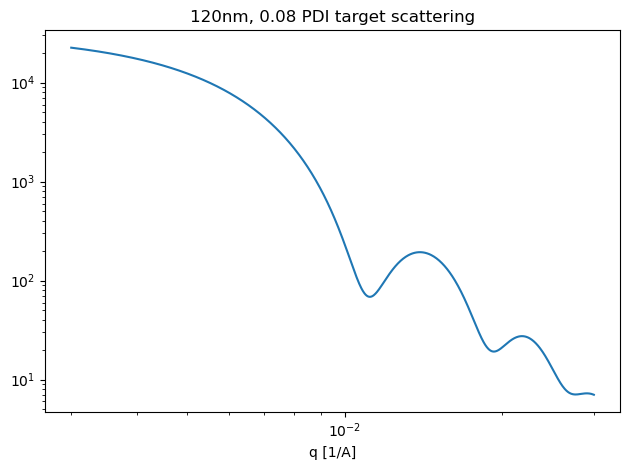

In [23]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')
ax.set_title('120nm, 0.08 PDI target scattering')
plt.tight_layout()
plt.savefig('target_profile_120nm.png', dpi = 300)

## Run full processing pipeline

In [24]:
processing_dataset = {}
counter = 0
for uuid_val, data_val in sample_data.items():
    print(f'{counter}: {uuid_val}')
    counter += 1
    meas_entry = {}
    meas_entry['original_data'] = data_val[0]
    background = uuid2bkg[uuid_val]
    meas_entry['background'] = background[0]
    # 1. Subtract background and select q range
    subtracted = subtract.chop_subtract(data_val[0], background[0], hiq_thresh=1)
    
    if subtracted is None:
        # if subtract returned None, data has issues and we are done with this sample
        meas_entry['status'] = 'failed'
        meas_entry['failure_point'] = 'background_subtraction'
        processing_dataset[uuid_val] = meas_entry
        print(f'Sample {uuid_val} failed at background subtraction')
        continue
        
    else:
        # q range selection
        subtracted = subtracted[subtracted['q'] < q_max_subtract]
        subtracted = subtracted[~subtracted['I'].isna()]
        subtracted = subtracted[subtracted['I'] > 0] # drop negative values 
        # screen on dataset length
        if len(subtracted) < min_data_len:
            meas_entry['status'] = 'failed'
            meas_entry['failure_point'] = 'subtracted_data_length'
            processing_dataset[uuid_val] = meas_entry
            print(f'Sample {uuid_val} failed due to data length')
            continue
        else:
            meas_entry['subtracted_clipped'] = subtracted
            meas_entry['status'] = 'valid'
            processing_dataset[uuid_val] = meas_entry


    # 2. Convert everything into log10 space
    q_log = np.log10(subtracted['q'].to_numpy())
    I_log = np.log10(subtracted['I'].to_numpy())

    meas_entry['q_log'] = q_log
    meas_entry['I_log'] = I_log
    
    # 3. denoise filter on intensity
    
    I_savgol = manipulate.denoise_intensity(I_log, savgol_n = savgol_n, savgol_order = savgol_order)

    meas_entry['I_savgol'] = I_savgol

    # 4. Spline fit and interpolate
    I_spline = manipulate.fit_interpolate_spline(q_log, I_savgol, q_grid, s = s, k = k)
    
    meas_entry['I_spline'] = I_spline

    # 5. scale onto target
    I_scaled = manipulate.scale_intensity_highqavg(I_spline, target_I, n_avg = n_avg)

    meas_entry['I_scaled'] = I_scaled

    #6. Calculate AP distance

    amplitude, phase = target_comparison.ap_distance(q_grid, I_scaled, target_I, optim = optim, grid_dim = grid_dim)

    ap_sum = amplitude + phase

    meas_entry['amplitude_distance'] = amplitude
    meas_entry['phase_distance'] = phase
    meas_entry['ap_sum_distance'] = ap_sum


    ## calculate raw RMSE
    meas_df = pd.DataFrame({'q':10**q_grid, 'I':10**I_scaled, 'sig':np.zeros(len(I_scaled))})
    #target_df = pd.DataFrame({'q':10**q_grid, 'I':10**target_I, 'sig':np.zeros(len(target_I))})
    
    raw_rmse = target_comparison.rmse_distance(I_scaled, target_I, log = False) # these intensities are already in log
    screened_rmse = target_comparison.calculate_distance_powerlawscreen(subtracted, meas_df, 10**target_I)

    meas_entry['rmse_raw'] = raw_rmse
    processing_dataset[uuid_val] = meas_entry
    

0: c563cb4d-d727-437f-9a6a-fef3eccbbe50


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


1: 3ef8b92f-f2eb-4134-ad6c-ae3329408457


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


2: 0507cf19-673b-4d6b-922e-c21f718ad4fe


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


3: 82fc5e1c-5d6e-4ecd-82c3-eb912535a0d7


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


4: 9964ab9f-5b01-4ae2-b492-a1be55ce083f


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


5: d263a9a8-70c2-49a4-badb-03a72fa16632


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


6: 586ae478-4dab-4d7d-9382-ab359a49387a
Sample 586ae478-4dab-4d7d-9382-ab359a49387a failed due to data length
7: 7386215f-7150-48a6-b35f-96cbe5b743cf


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


8: d408858a-bbae-4227-8e64-6c368a1f3398


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


9: 0c042bd5-e5ed-4460-9bb9-d8556dba293c


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


10: 8fbd8649-0d61-4edc-9fe3-1ca354becc5a


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


11: d4ebf798-d856-406f-9732-f11da412170b


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


12: e44ddf37-b7d0-420b-bf6c-02535ca6803a


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


13: 238ebc43-fbc1-4049-b506-1dc041dedb42


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


14: 8aacf82b-9869-48dd-ad8a-85eaca6ce824


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


15: a635324c-8eea-4566-af05-e39d8101ef91


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


16: 08f1d123-975c-4dca-b962-6134f27e4ddc


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


17: d91aa15e-1296-4485-94d0-0cf924b116de


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


18: 1537344f-106d-4cb9-b1de-3262334f8665


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


19: 7c2bc3ea-ff76-42ba-88f9-86fb14a0f437


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


20: 1ec7142f-1f4f-44ee-965b-da3a052e0b2a


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


21: 13735048-3ac7-447e-8bca-7af4fda689cb


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


22: f041b533-6c1d-4be3-aa7b-01521b804bf8


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


23: 1c5c16fb-5f52-451d-a370-36a6418ab246


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


24: 0a4b4bec-376d-4106-853e-53c50b36e515


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


25: ee885bbe-4e05-426d-9772-0e1e3293e727


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


26: da675871-7139-4a31-8e76-317fb87385fa


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


27: 9f769eed-2173-4aa3-b71b-60f6488e526f
1.254131284844074
1.1403261915510066
78


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


28: c62bf89a-0e46-4e1c-9e83-89c38787a58e


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


29: 77c8bfe5-d105-433e-8fcc-12675094a30e


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


30: fa064c37-87e6-4f7f-9189-02b4ddf6dd6e
1.1525612831486625
0.542660143398656
96


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


31: 4808d774-6c9b-4436-86ed-5355d9731910


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


### Sanity check subtraction

c563cb4d-d727-437f-9a6a-fef3eccbbe50
3ef8b92f-f2eb-4134-ad6c-ae3329408457
0507cf19-673b-4d6b-922e-c21f718ad4fe
82fc5e1c-5d6e-4ecd-82c3-eb912535a0d7
9964ab9f-5b01-4ae2-b492-a1be55ce083f
d263a9a8-70c2-49a4-badb-03a72fa16632
586ae478-4dab-4d7d-9382-ab359a49387a
failed at  subtracted_data_length
7386215f-7150-48a6-b35f-96cbe5b743cf
d408858a-bbae-4227-8e64-6c368a1f3398
0c042bd5-e5ed-4460-9bb9-d8556dba293c
8fbd8649-0d61-4edc-9fe3-1ca354becc5a
d4ebf798-d856-406f-9732-f11da412170b
e44ddf37-b7d0-420b-bf6c-02535ca6803a
238ebc43-fbc1-4049-b506-1dc041dedb42
8aacf82b-9869-48dd-ad8a-85eaca6ce824
a635324c-8eea-4566-af05-e39d8101ef91
08f1d123-975c-4dca-b962-6134f27e4ddc
d91aa15e-1296-4485-94d0-0cf924b116de
1537344f-106d-4cb9-b1de-3262334f8665
7c2bc3ea-ff76-42ba-88f9-86fb14a0f437
1ec7142f-1f4f-44ee-965b-da3a052e0b2a
13735048-3ac7-447e-8bca-7af4fda689cb
f041b533-6c1d-4be3-aa7b-01521b804bf8
1c5c16fb-5f52-451d-a370-36a6418ab246
0a4b4bec-376d-4106-853e-53c50b36e515
ee885bbe-4e05-426d-9772-0e1e3293e727
da67

/tmp/ipykernel_2434/1424264336.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


4808d774-6c9b-4436-86ed-5355d9731910


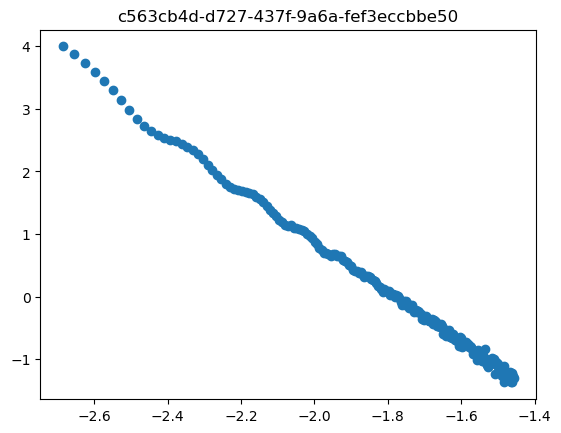

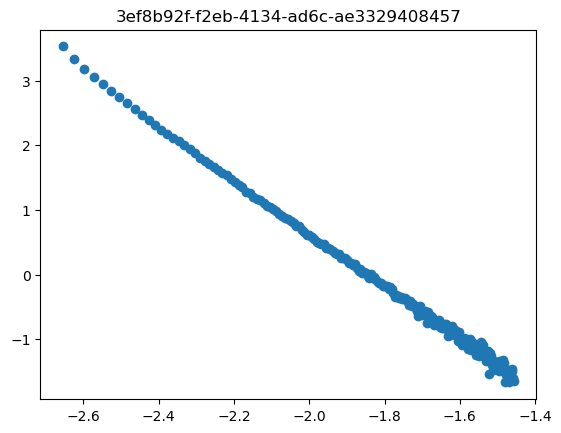

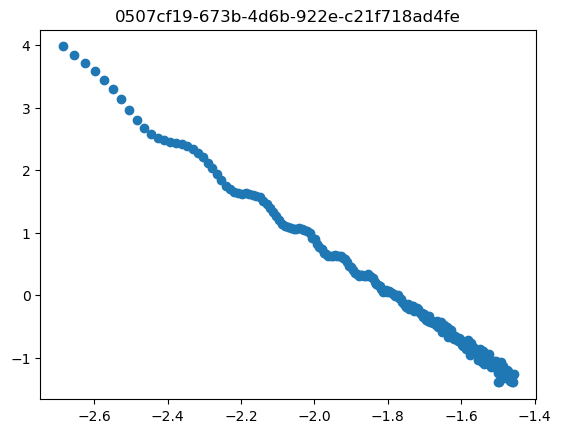

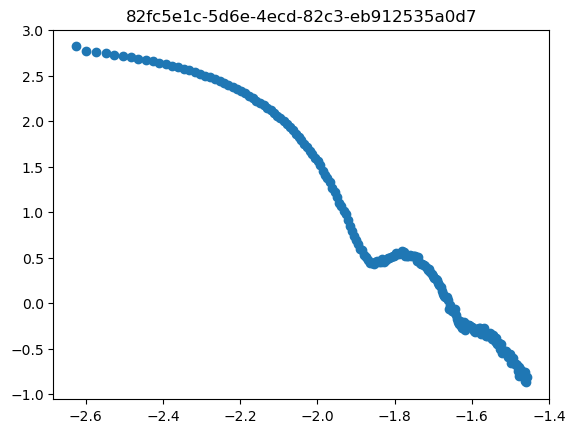

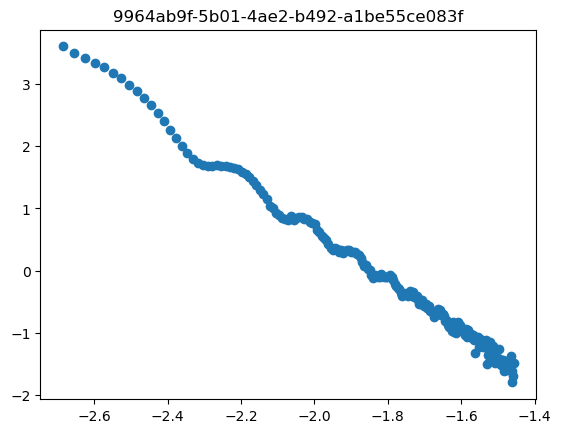

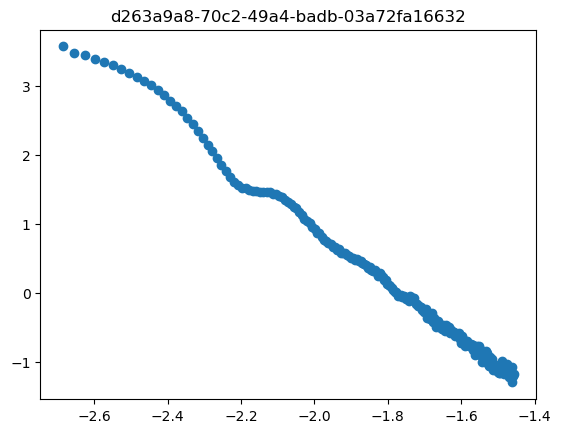

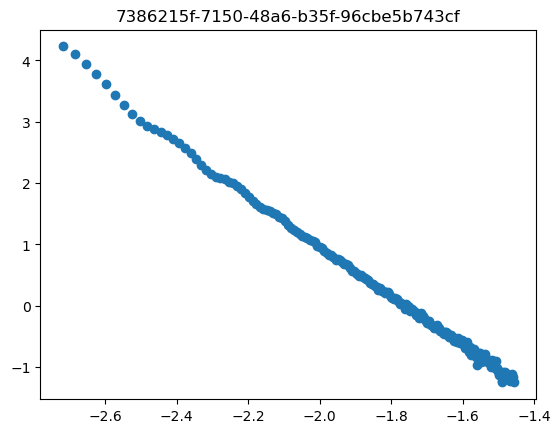

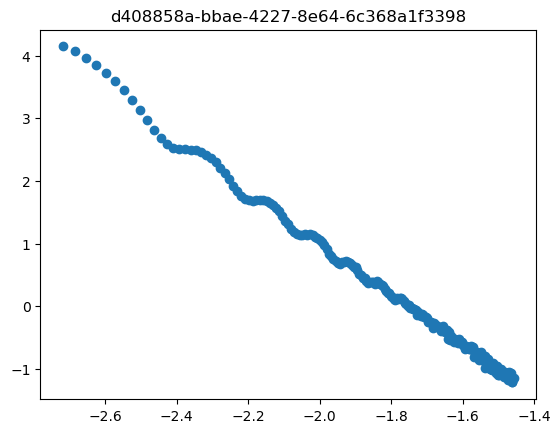

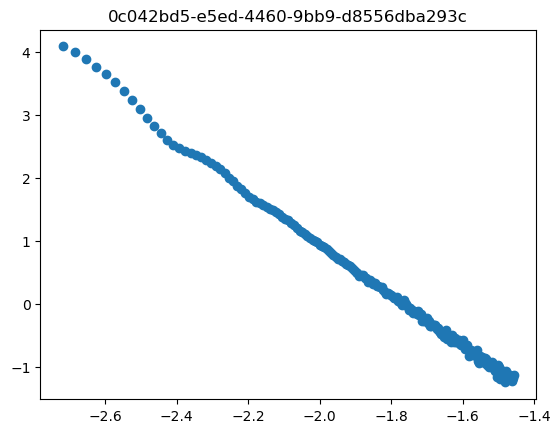

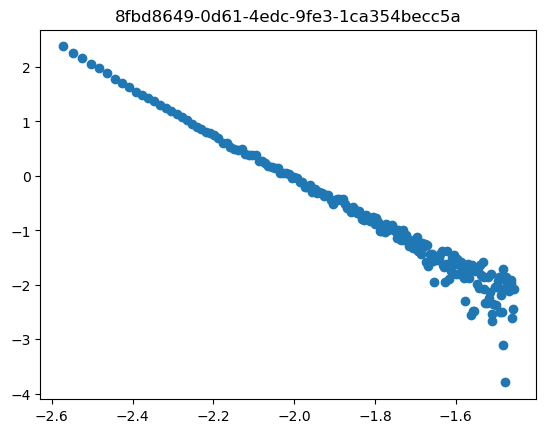

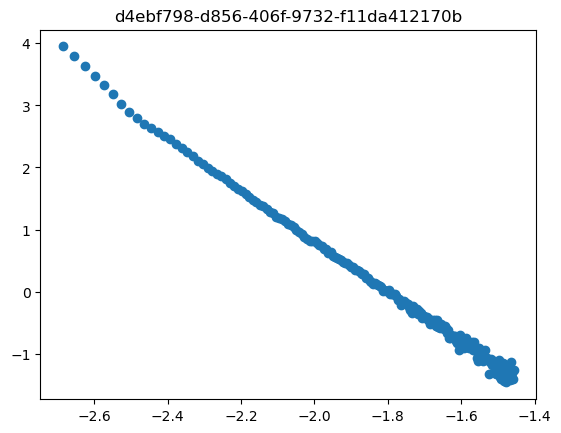

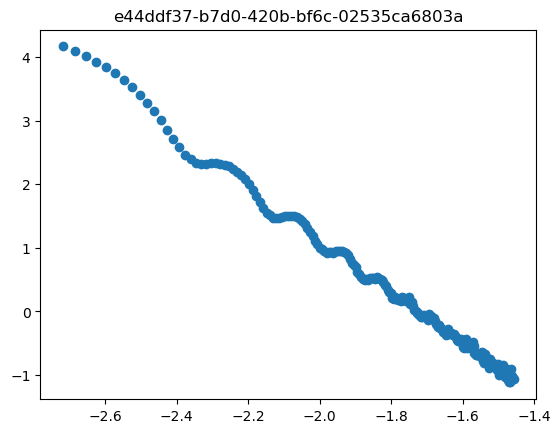

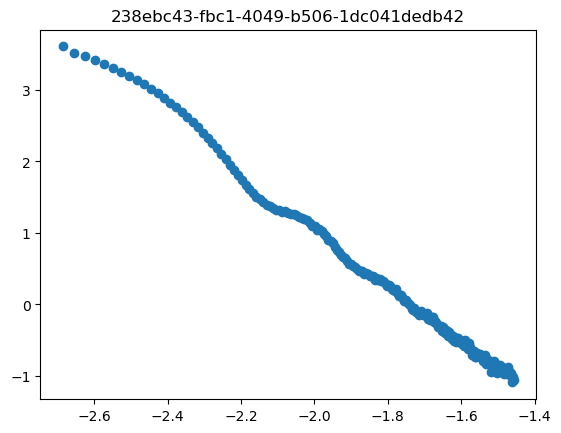

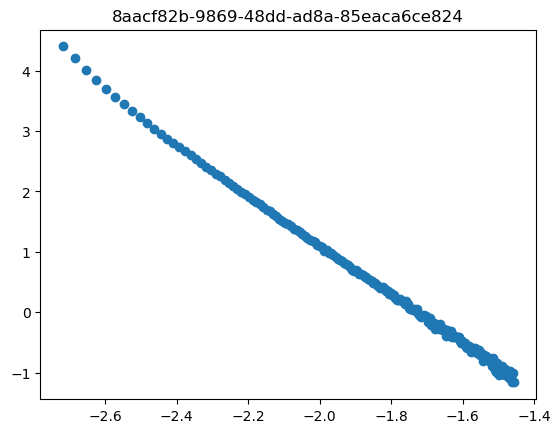

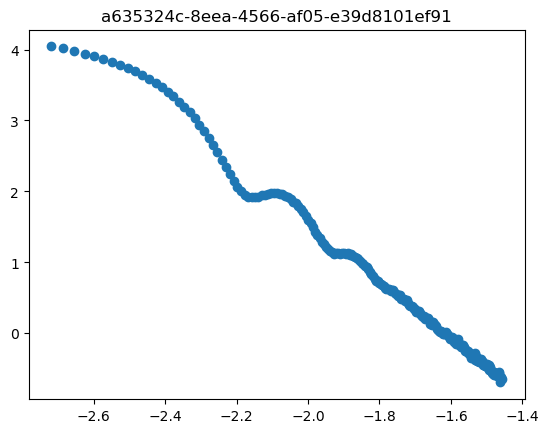

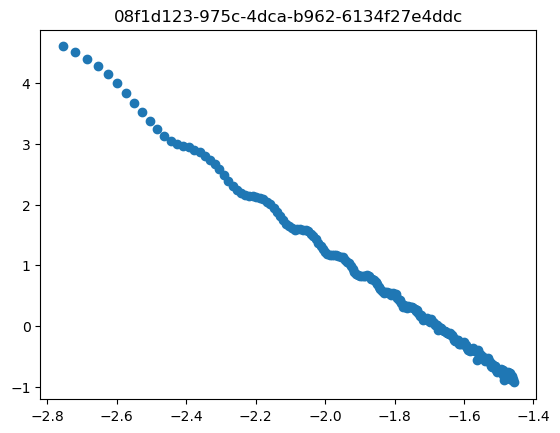

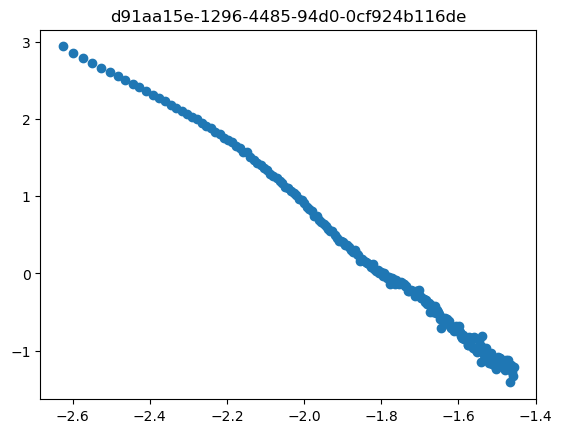

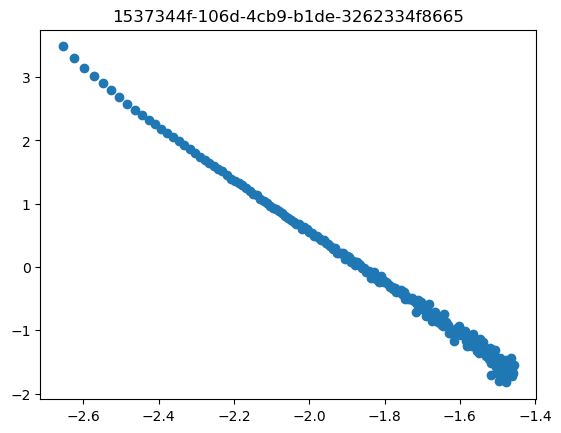

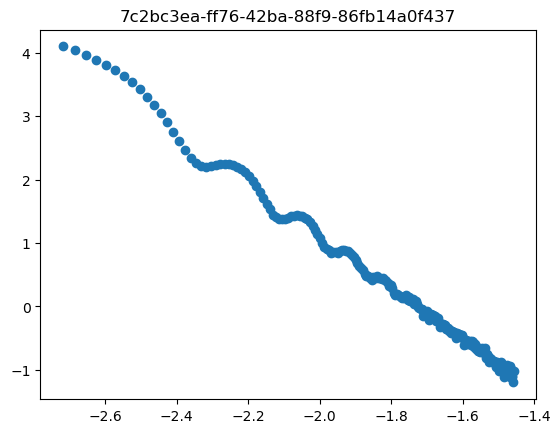

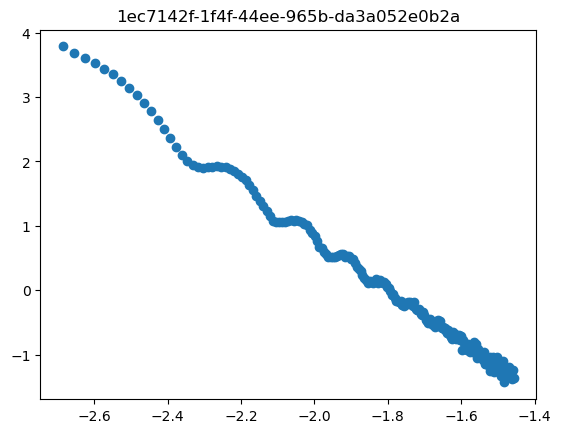

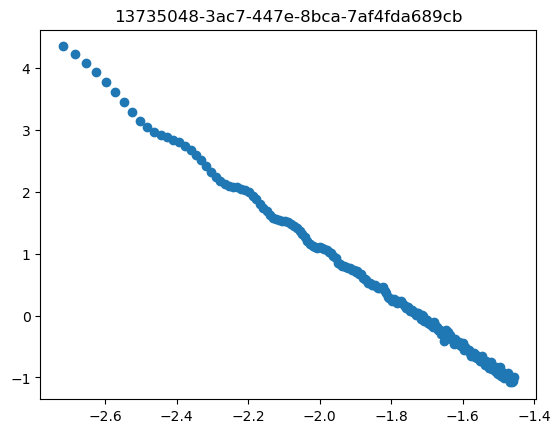

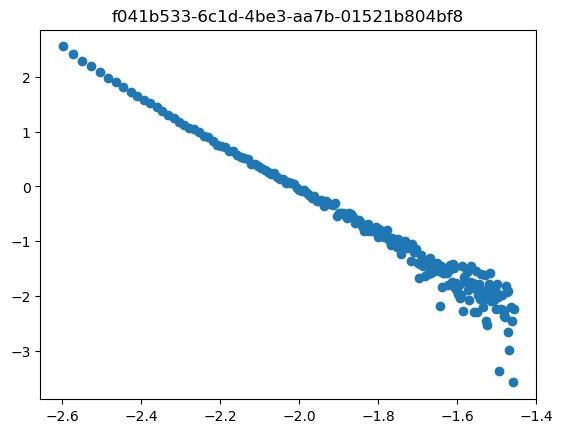

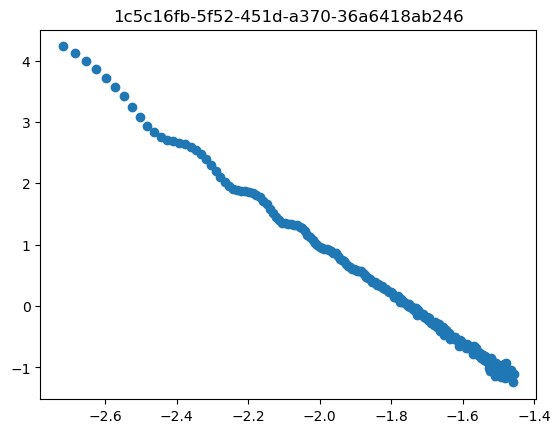

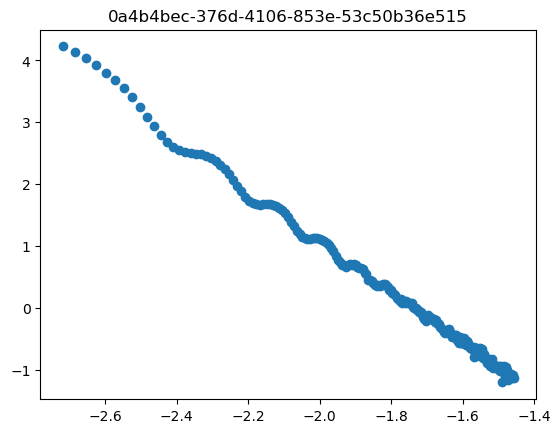

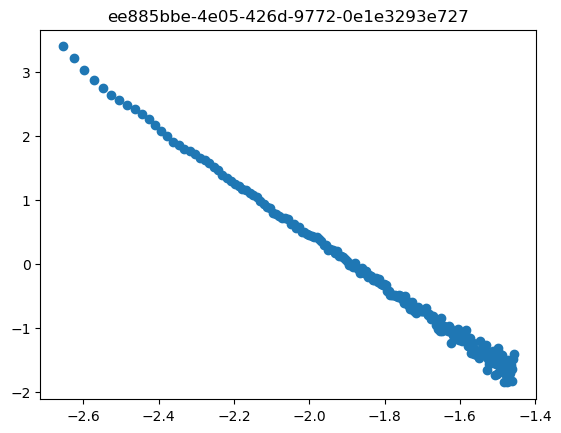

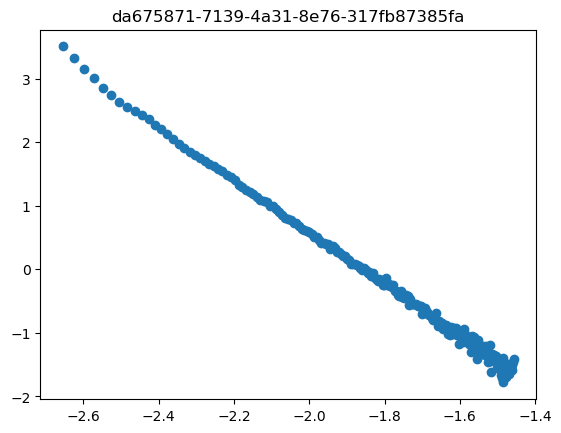

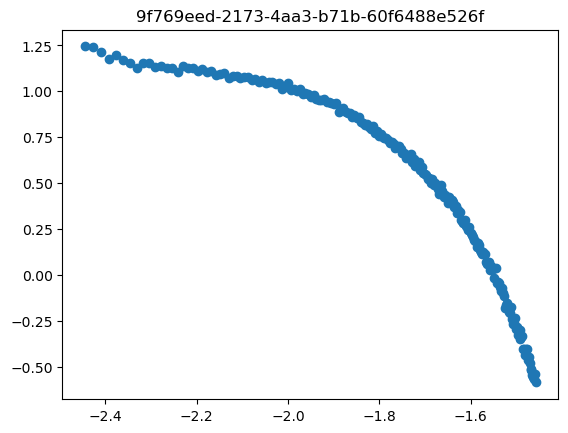

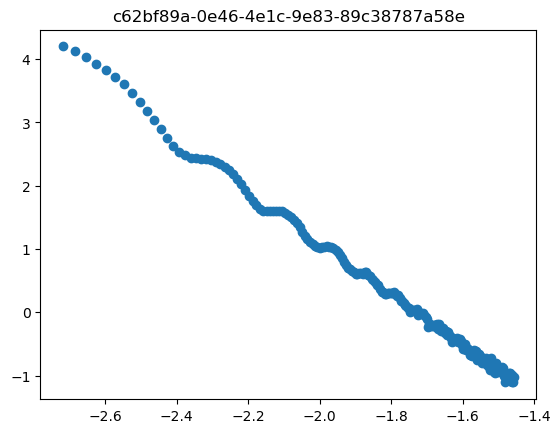

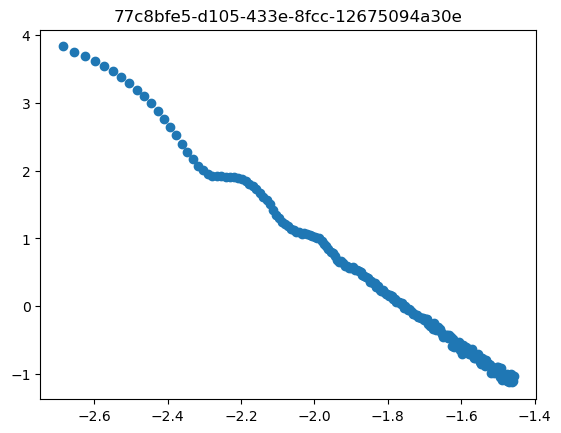

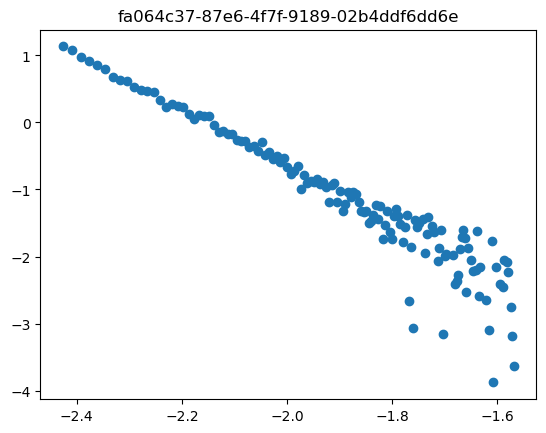

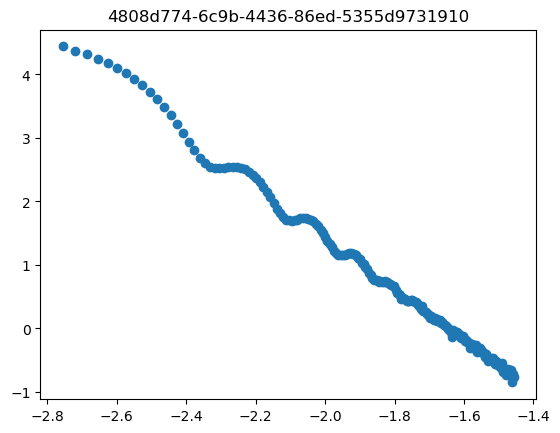

In [27]:
for uuid_val, entry in processing_dataset.items():
    print(uuid_val)
    try:
        status = entry['status']
        if status == 'failed':
            print('failed at ', entry['failure_point'])
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()
    
        I_subtracted = entry['I_log']
        q = entry['q_log']
    
        ax.scatter(q, I_subtracted)
        ax.set_title(uuid_val)

## Sanity check spline fit

/tmp/ipykernel_2434/3859189070.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


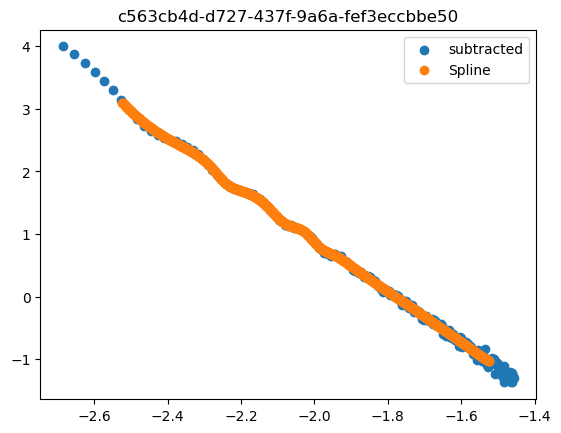

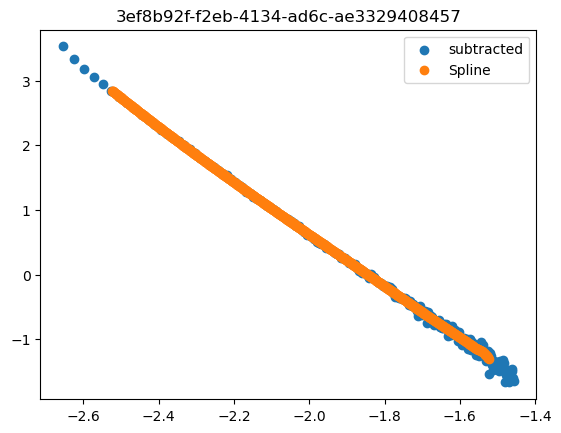

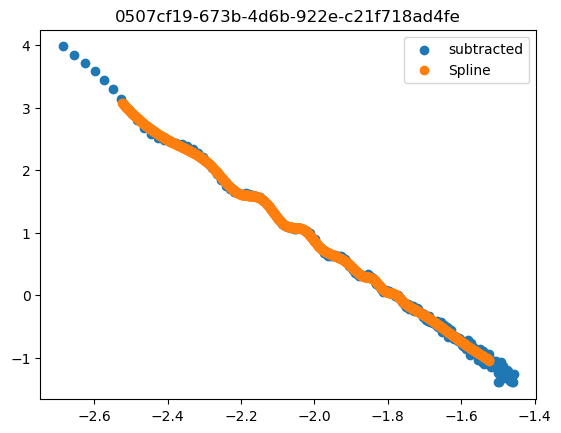

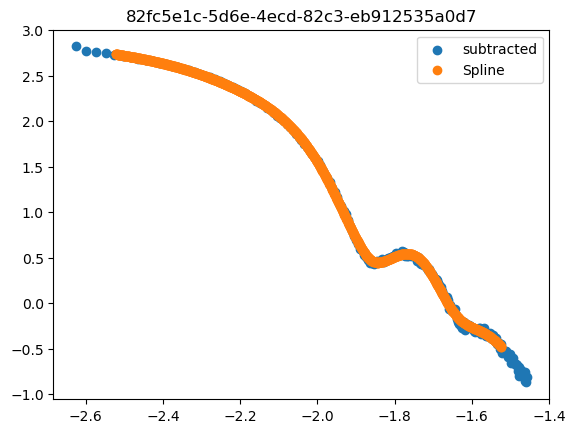

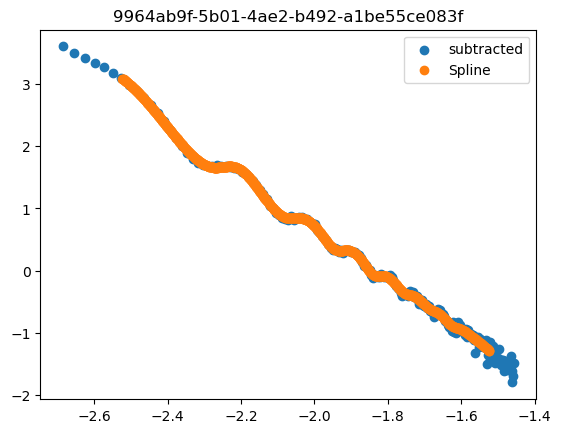

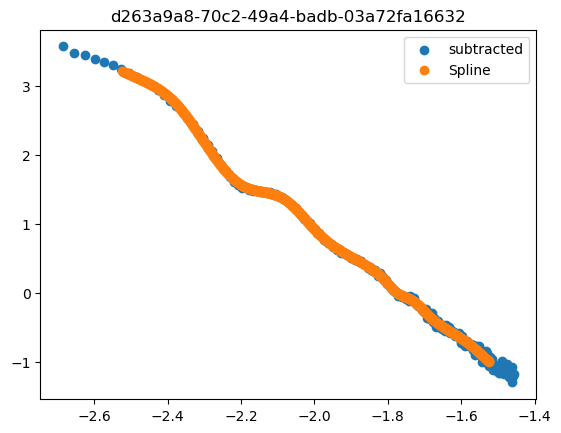

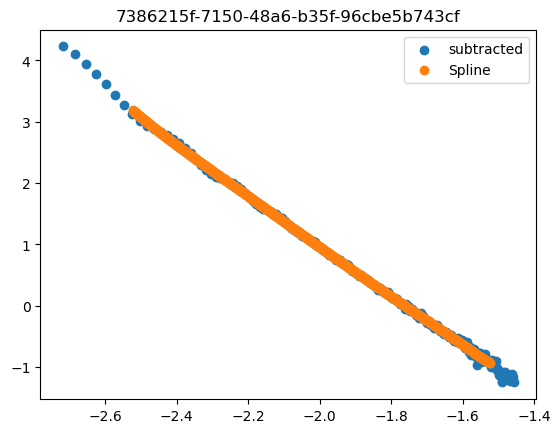

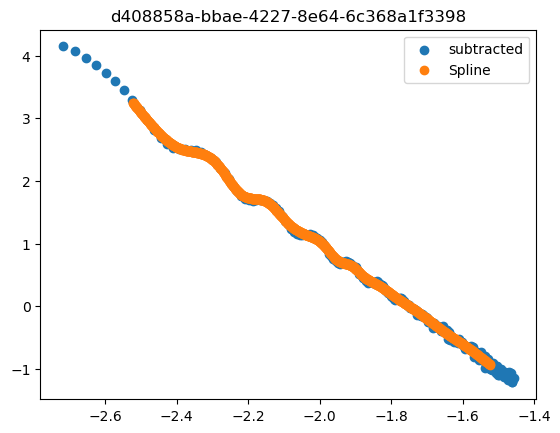

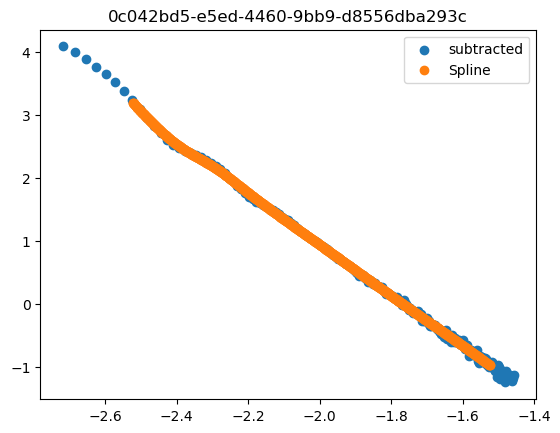

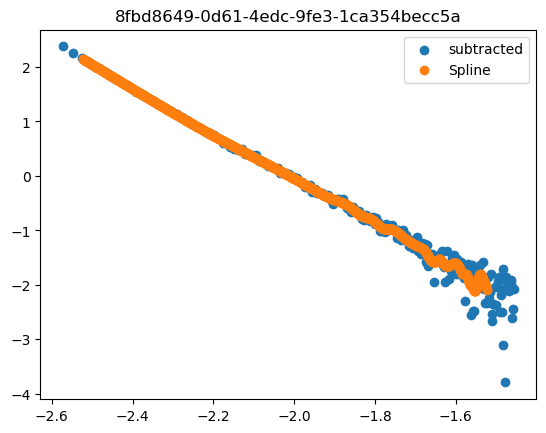

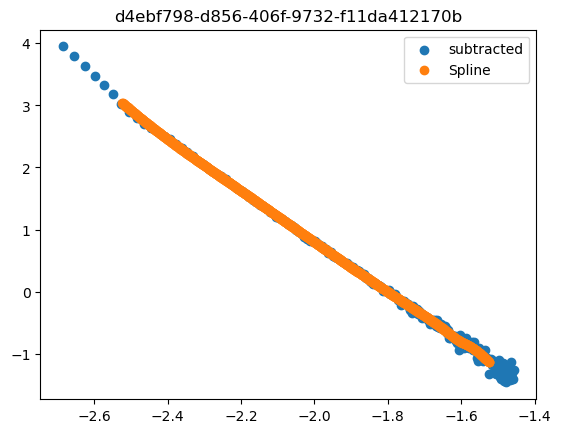

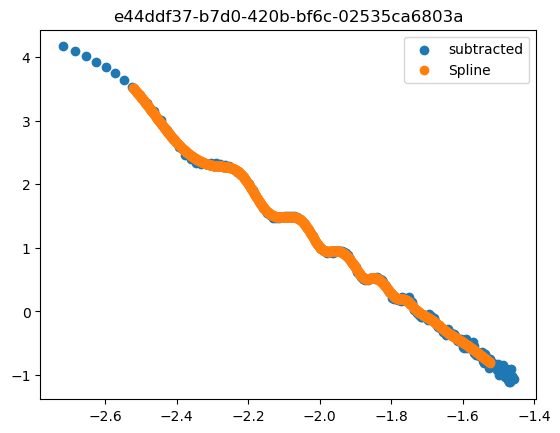

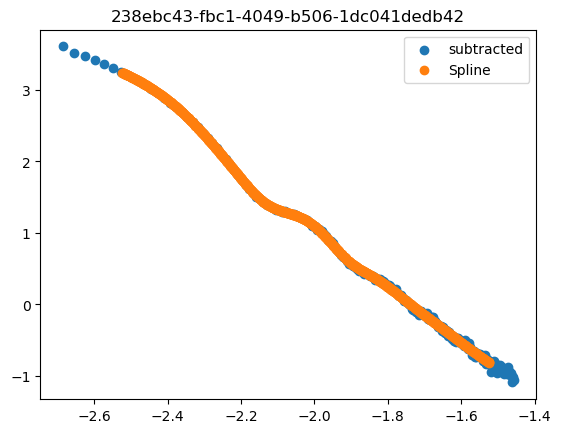

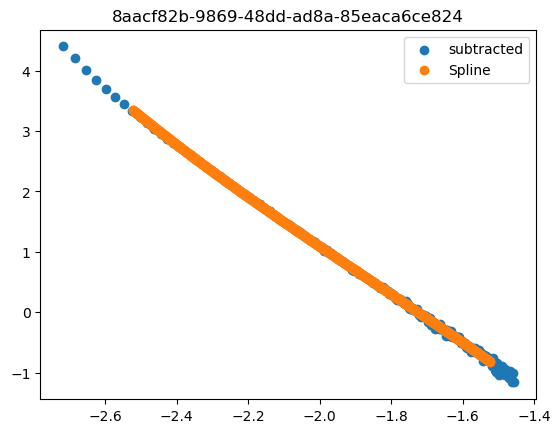

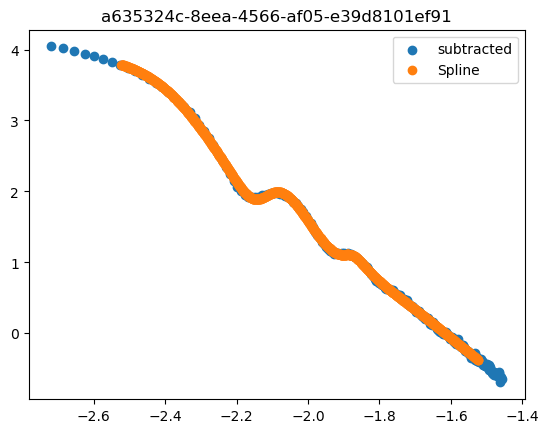

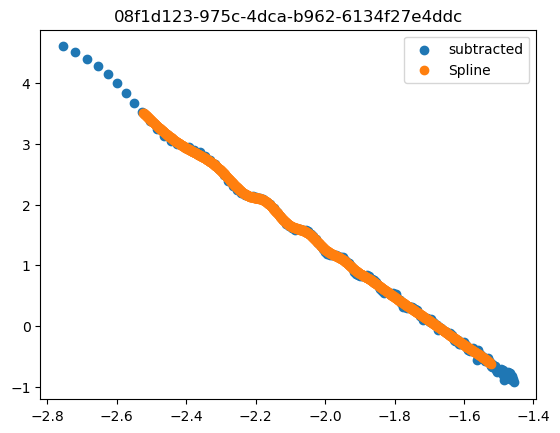

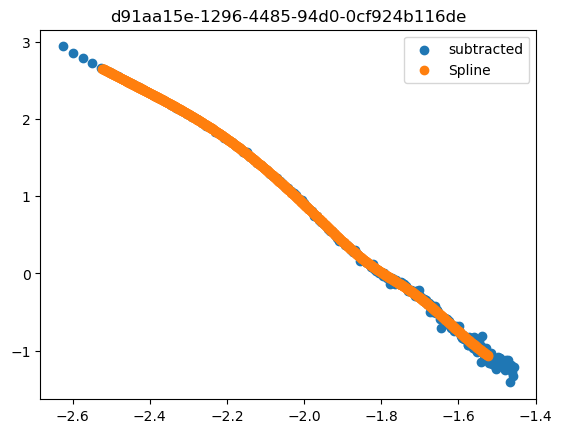

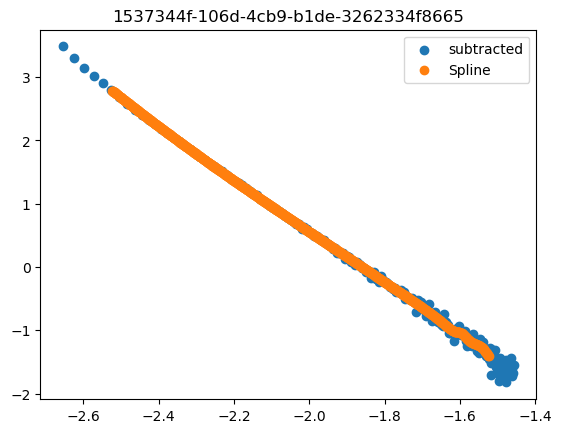

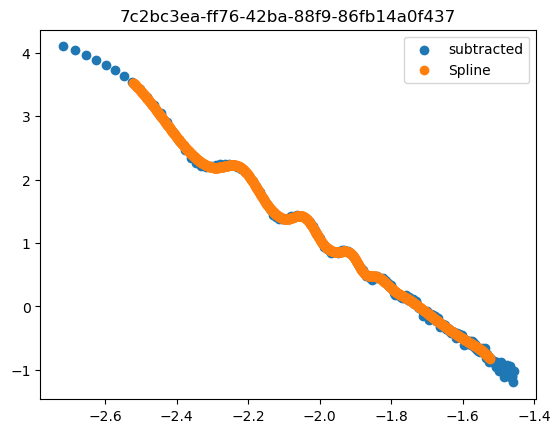

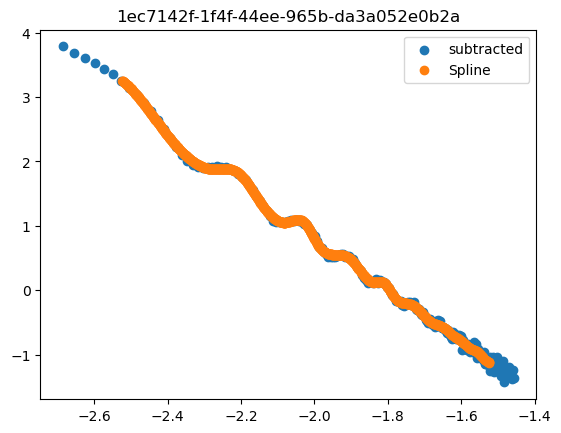

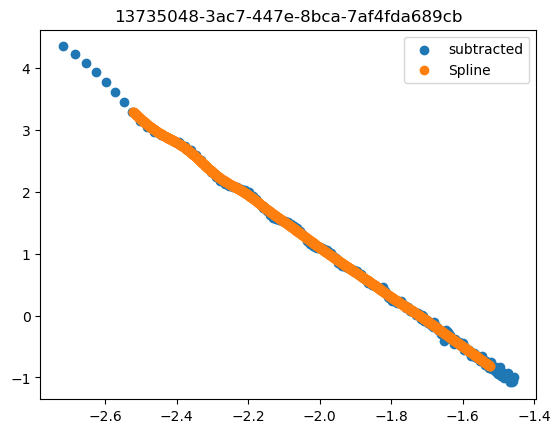

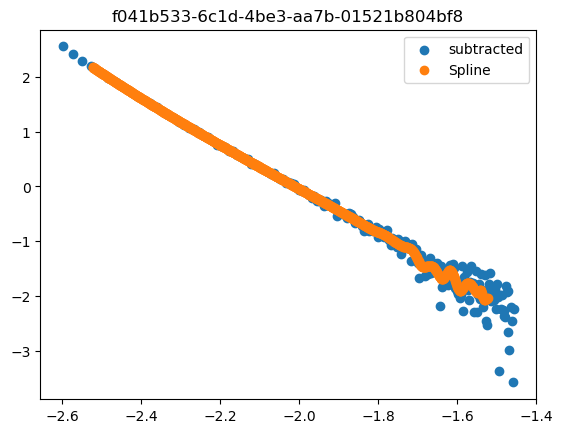

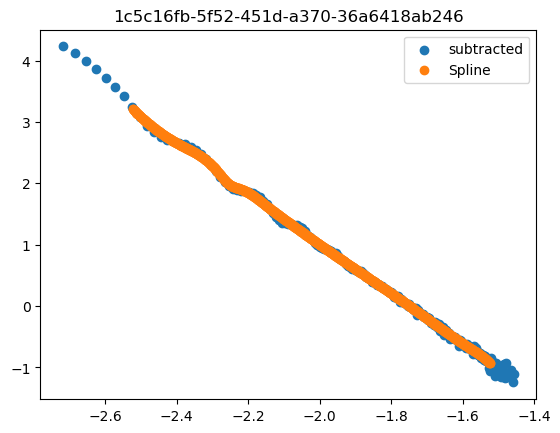

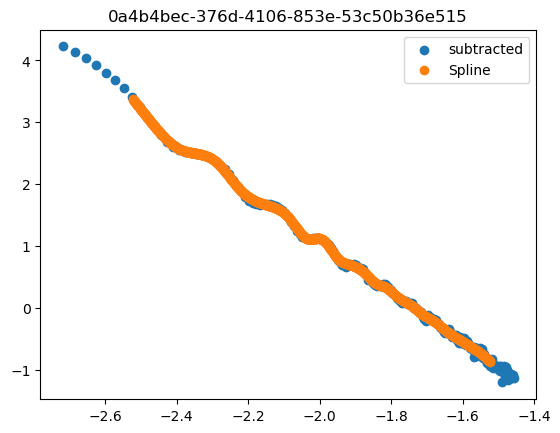

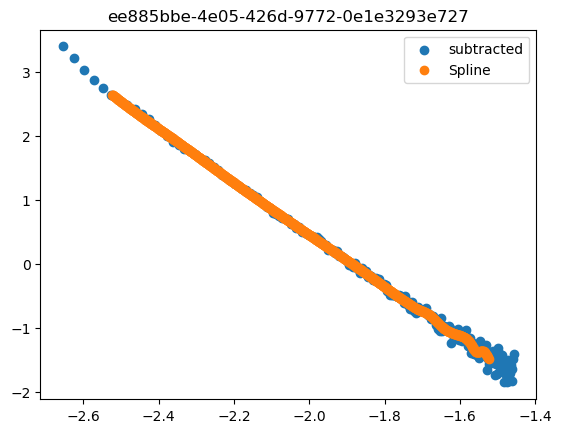

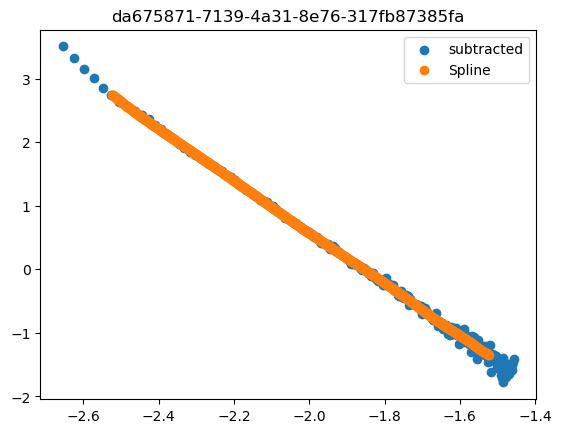

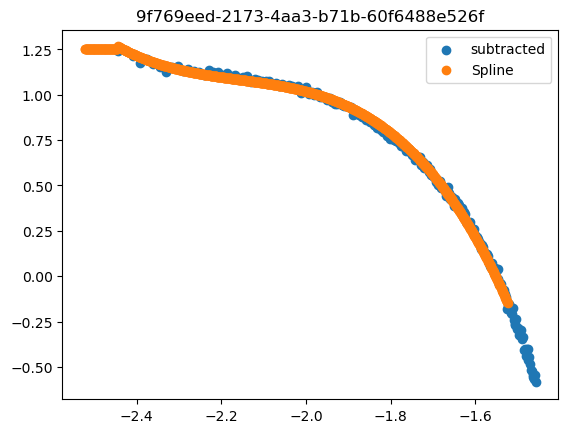

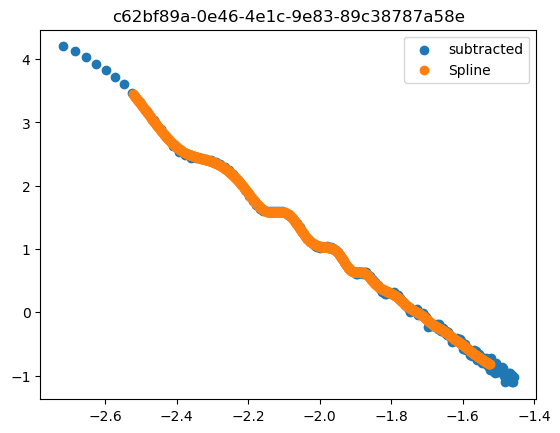

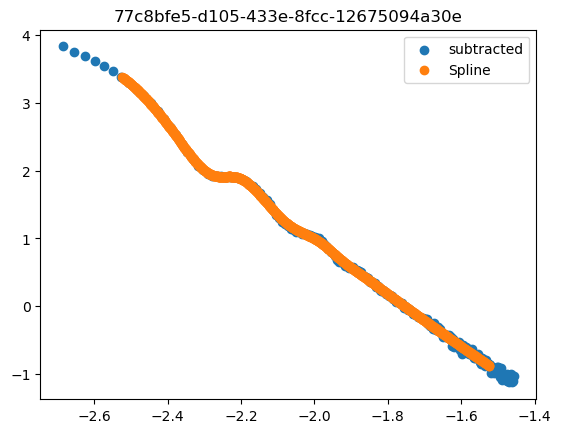

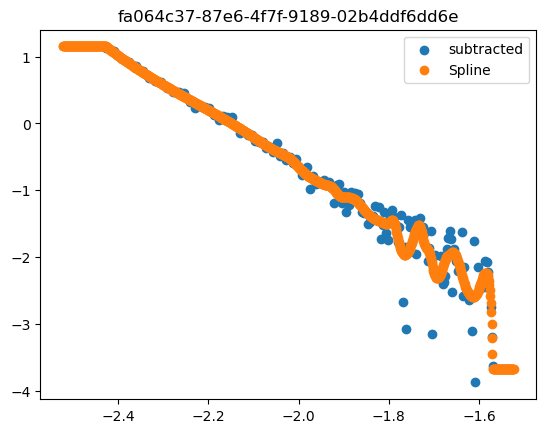

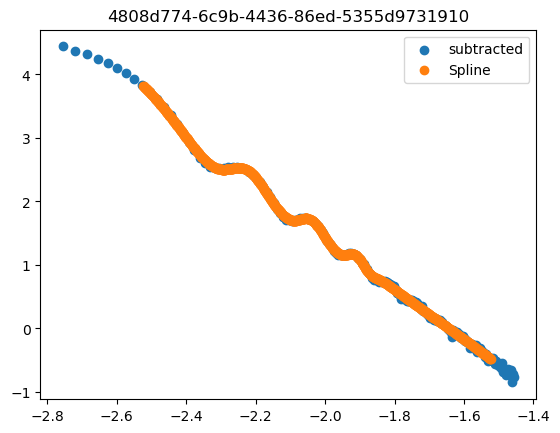

In [28]:
for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()
    
        I_subtracted = entry['I_log']
        q = entry['q_log']

        I_spline = entry['I_spline']
        
    
        ax.scatter(q, I_subtracted, label = 'subtracted')
        ax.scatter(q_grid, I_spline, label = 'Spline')
        ax.legend()
        ax.set_title(uuid_val)

## Sanity check scaling

/tmp/ipykernel_2434/1900914898.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


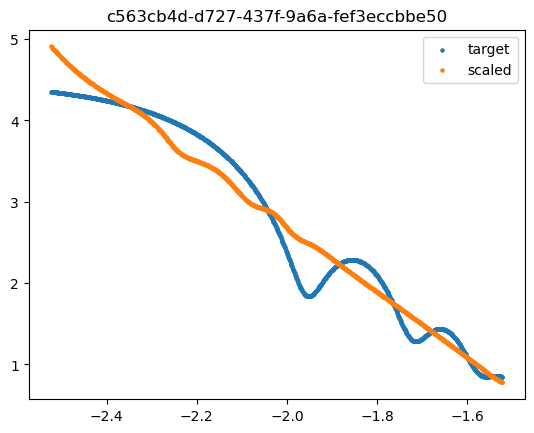

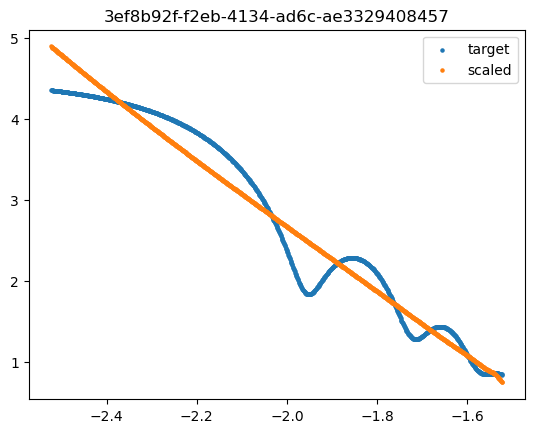

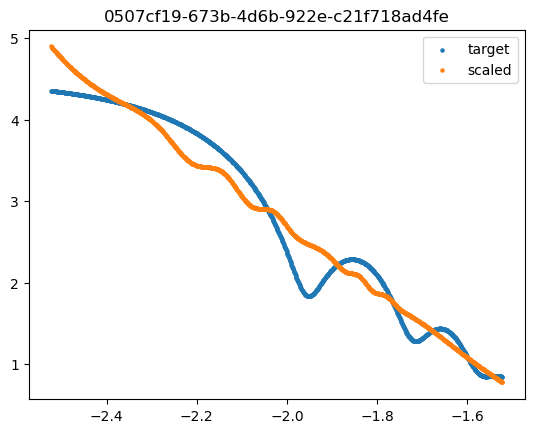

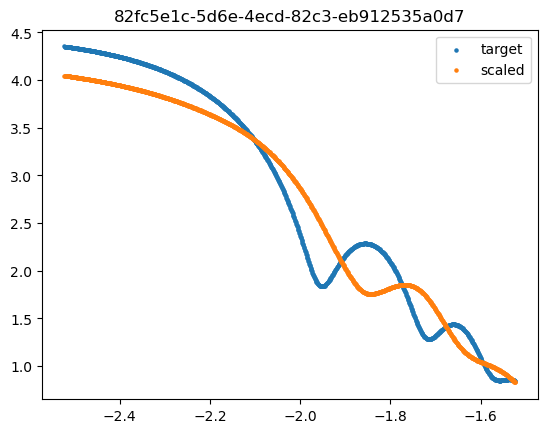

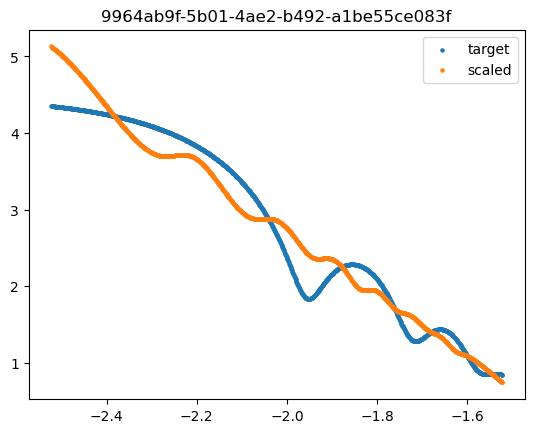

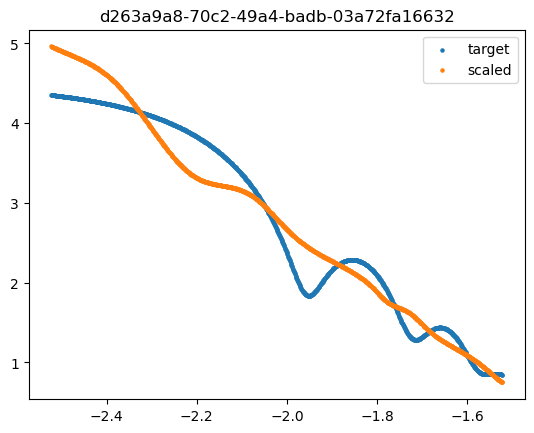

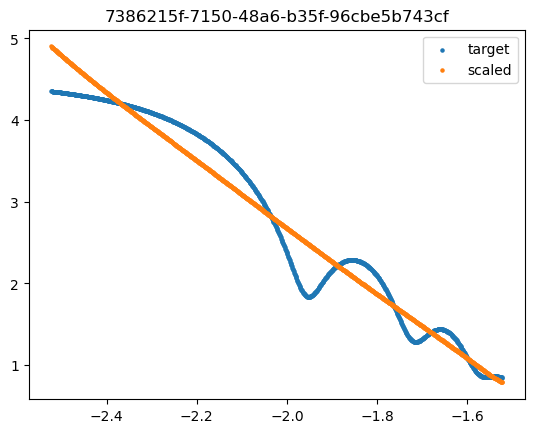

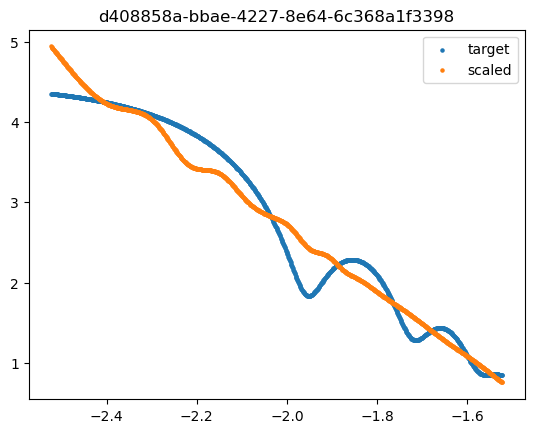

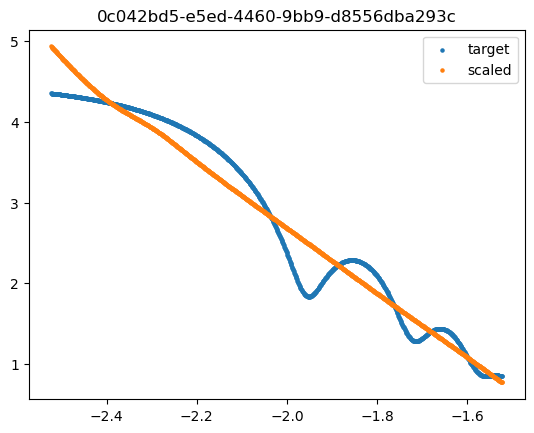

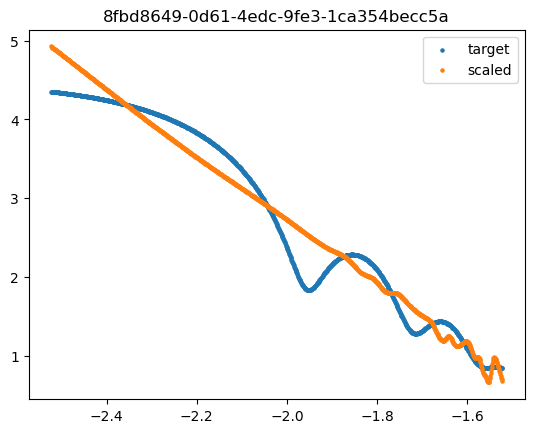

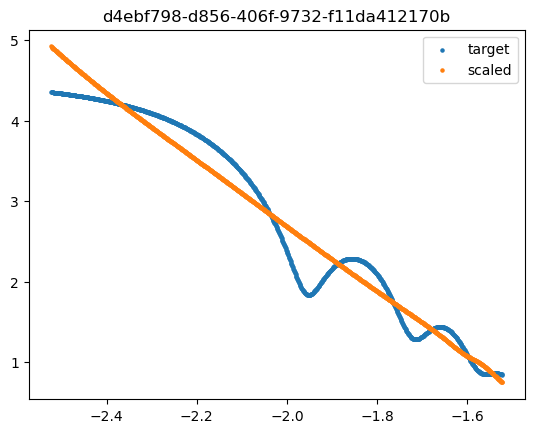

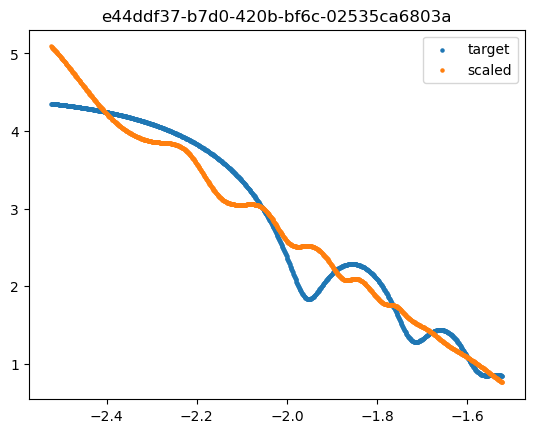

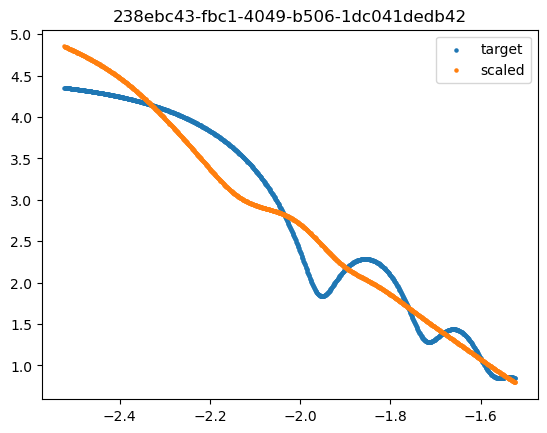

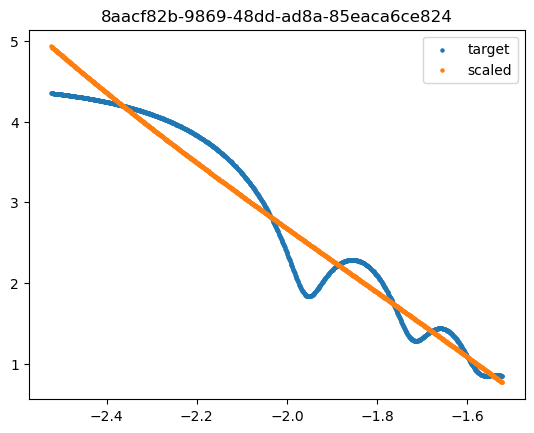

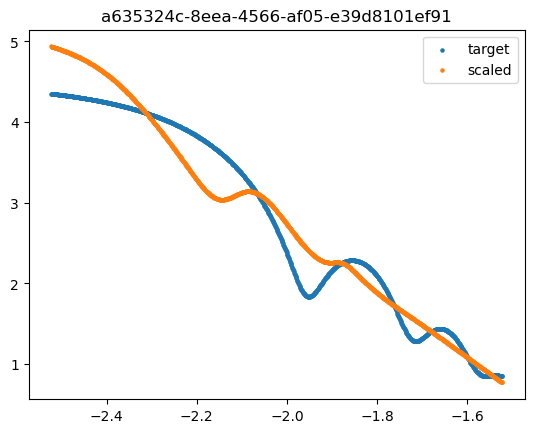

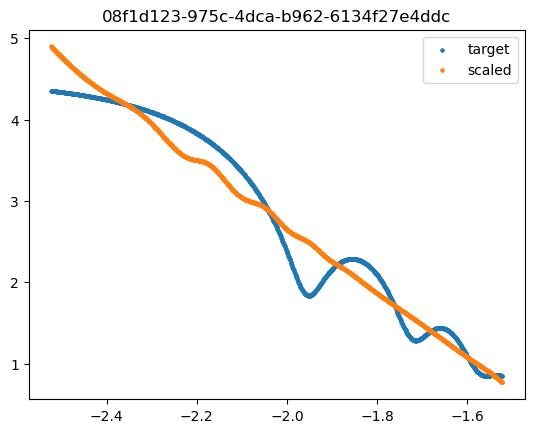

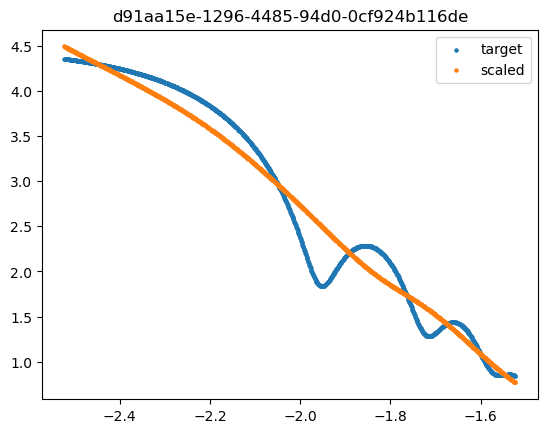

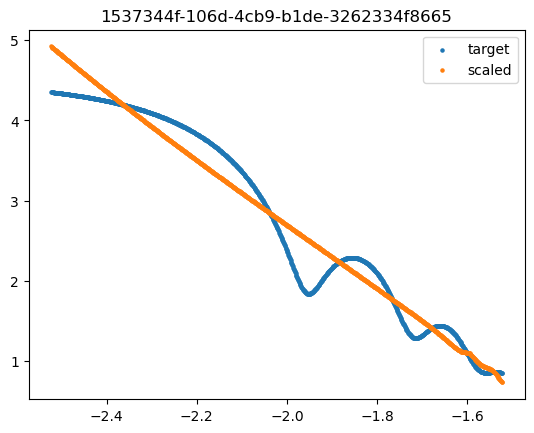

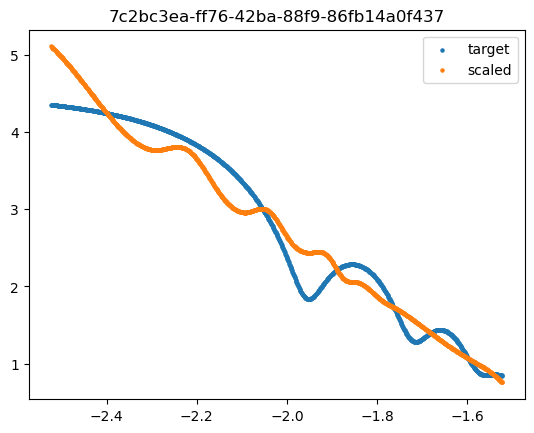

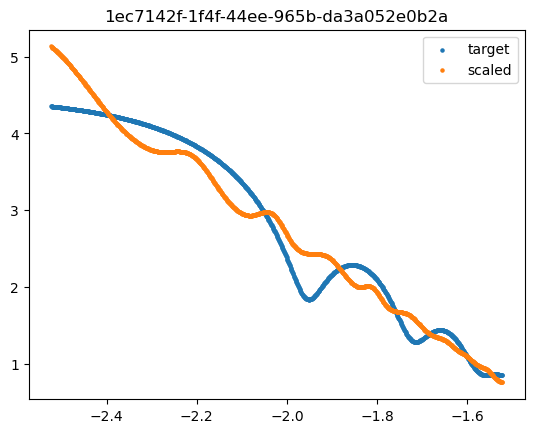

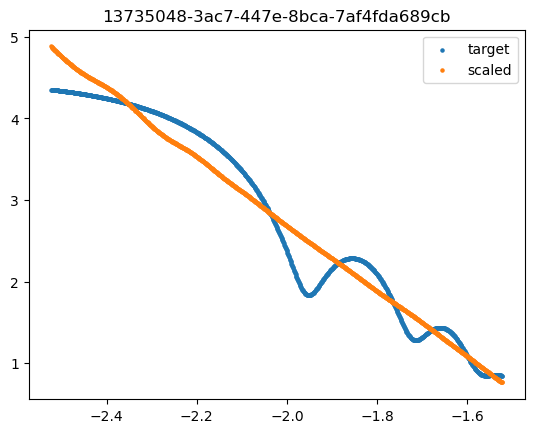

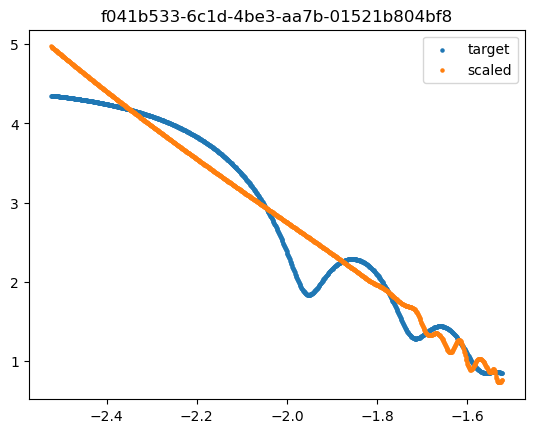

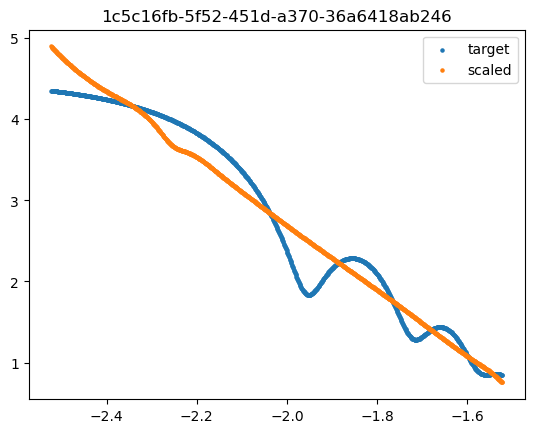

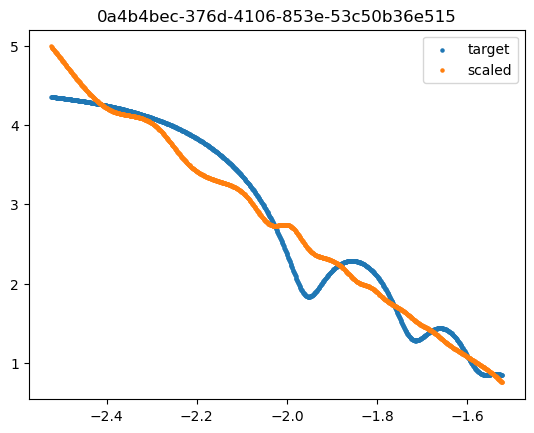

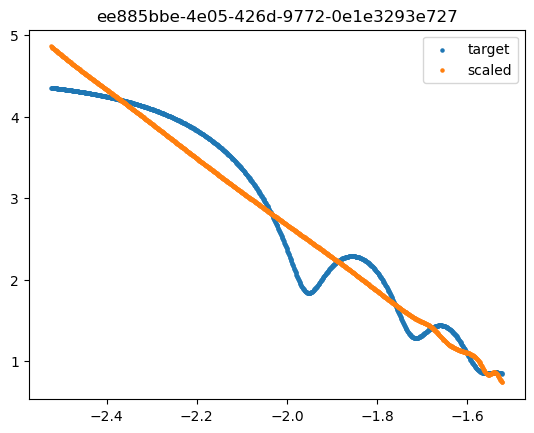

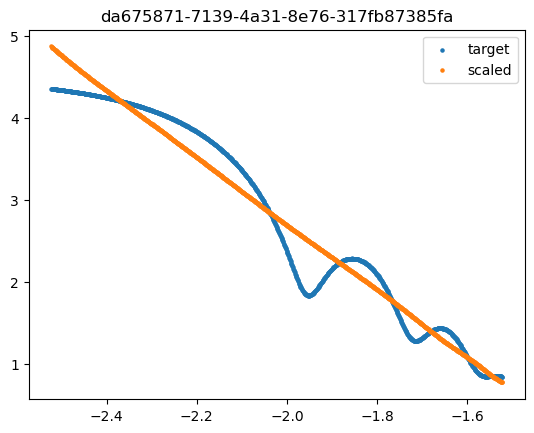

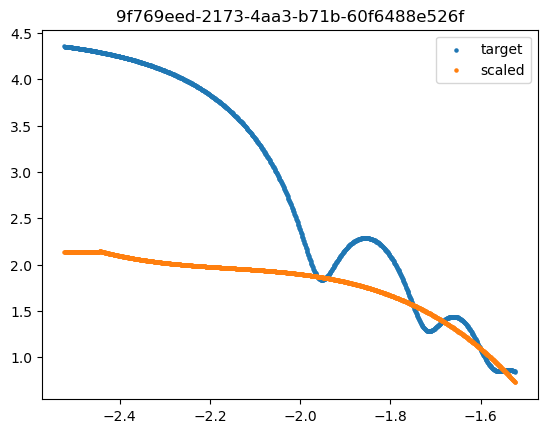

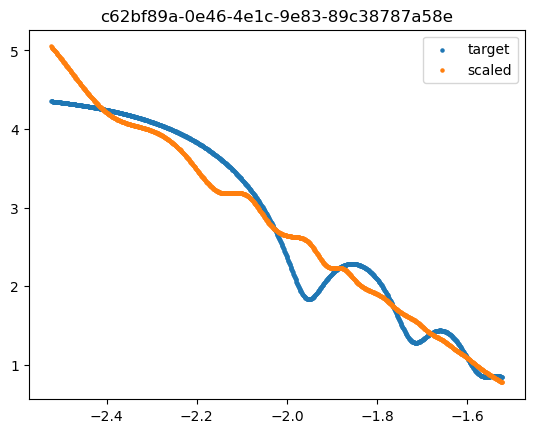

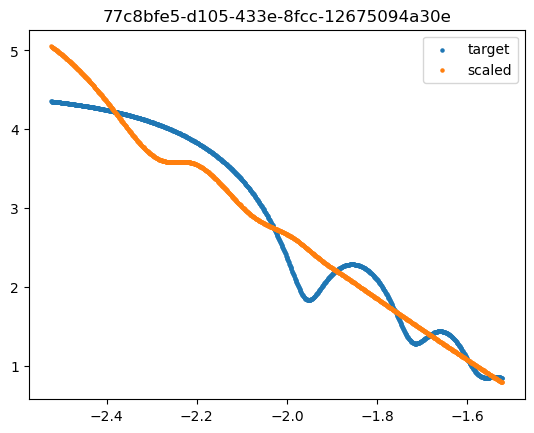

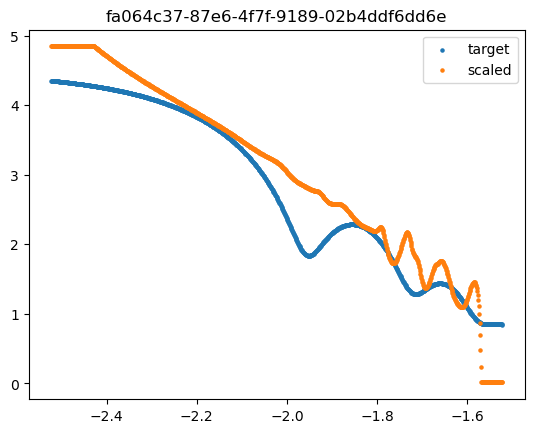

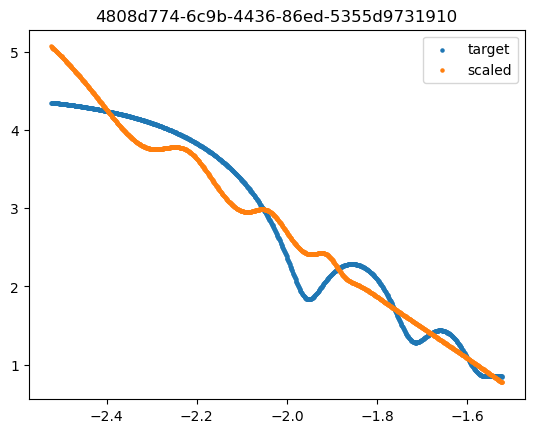

In [29]:
for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()


        I_scaled = entry['I_scaled']
        
    
        ax.scatter(q_grid, target_I, label = 'target', s = 5)
        ax.scatter(q_grid, I_scaled, label = 'scaled', s = 5)
        ax.legend()
        ax.set_title(uuid_val)

## Fit sphere model

In [30]:
for uuid_val, entry in processing_dataset.items():
    try:
        subtracted = entry['subtracted_clipped']
    except KeyError:
        continue
        
    data_sas = io.df_to_sasdata(subtracted)
    results, result_obj, problem  = sasview_fitting.fit_sphere(data_sas, polydispersity=True, r_init=50, pd_init = 0, pd_distribution='lognormal')

    processing_dataset[uuid_val]['sphere_fit_results'] = results
    processing_dataset[uuid_val]['sphere_fit_problem'] = problem

In [31]:
diameters = {}
pdi_vals = {}

for uuid_val, entry in processing_dataset.items():
    try:
        sphere_results = entry['sphere_fit_results']
        d = sphere_results['radius']*2/10
        pdi = sphere_results['radius_pd']
        diameters[uuid_val] = d
        pdi_vals[uuid_val] = pdi
    except KeyError:
        continue

## sanity check fit results

/tmp/ipykernel_2434/2583699091.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


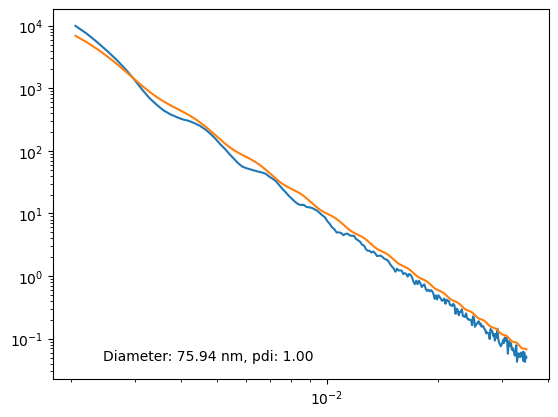

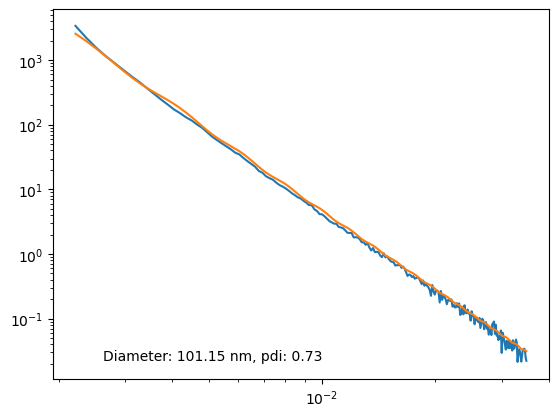

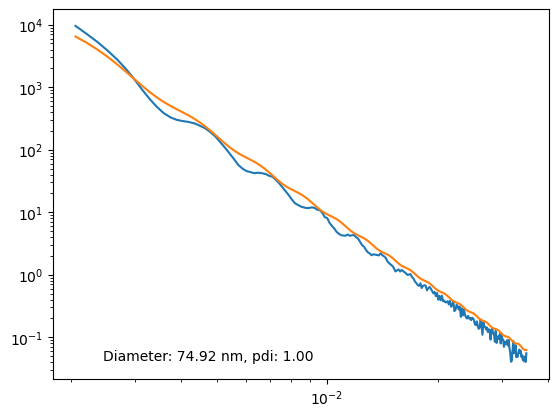

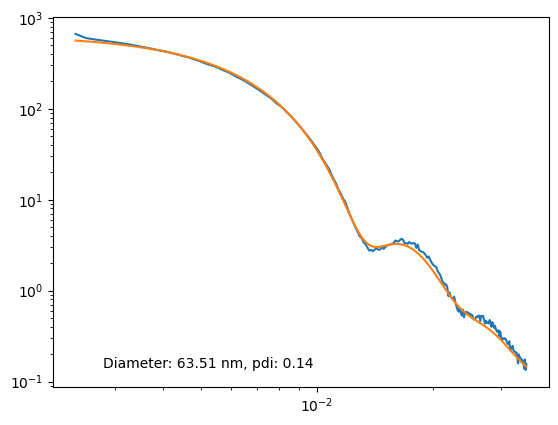

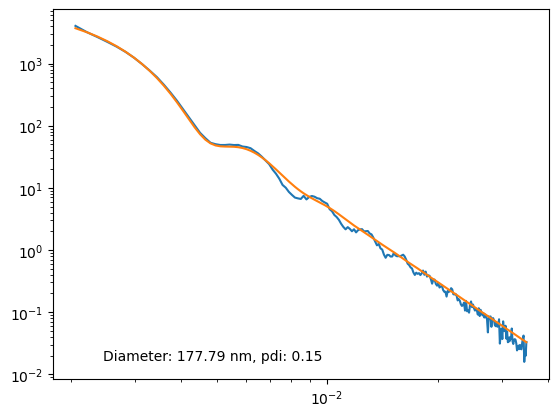

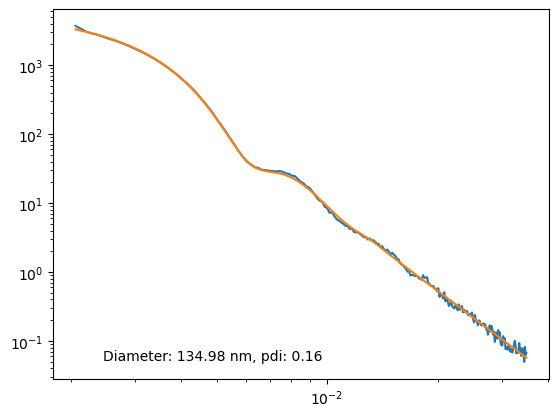

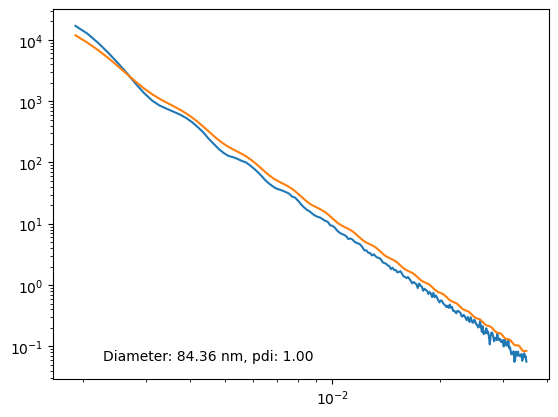

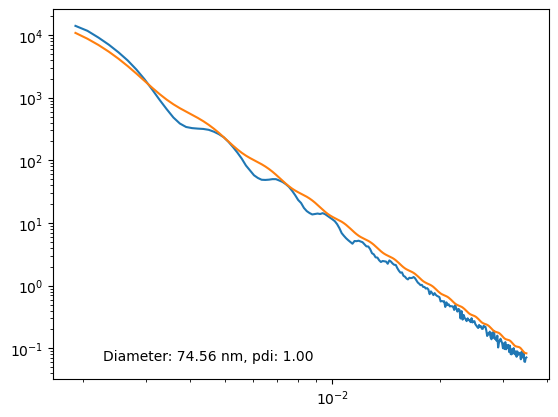

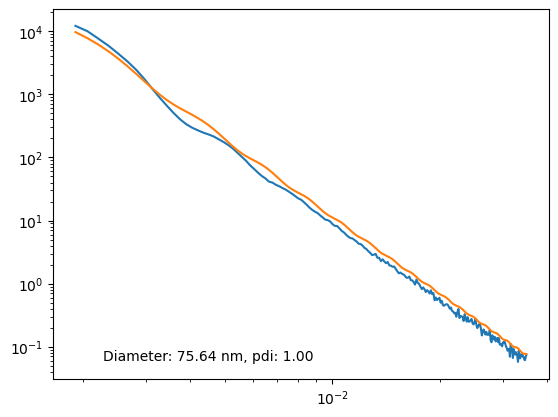

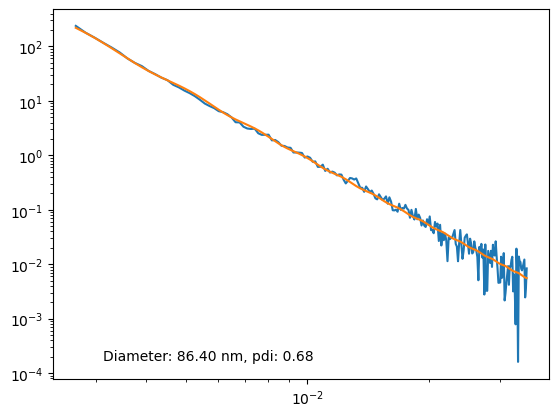

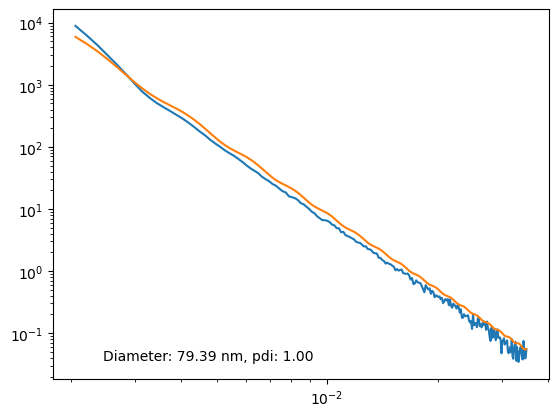

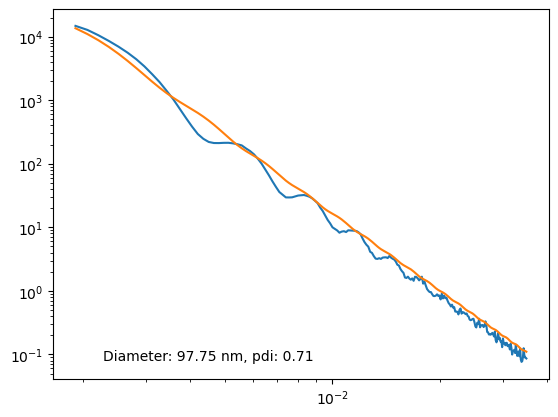

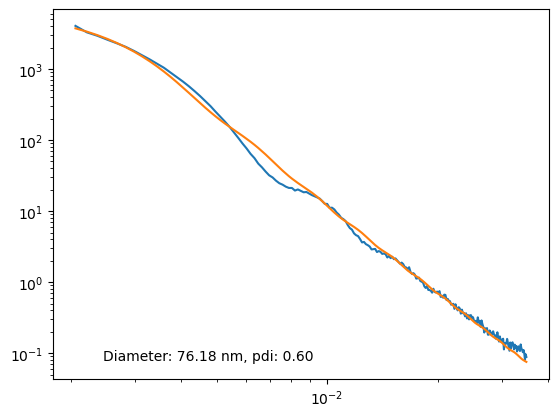

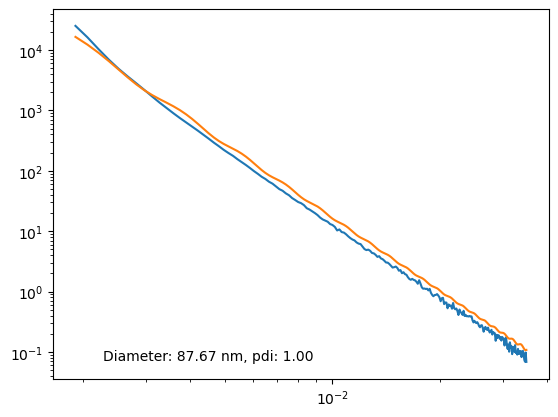

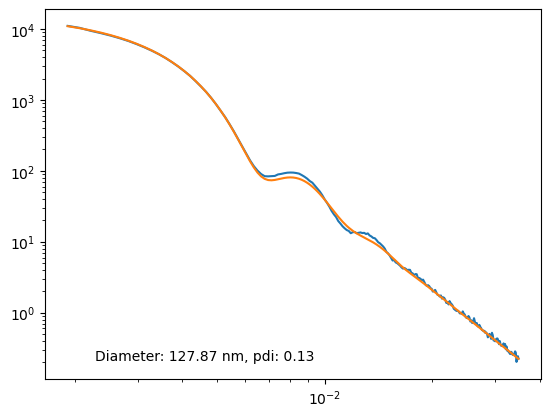

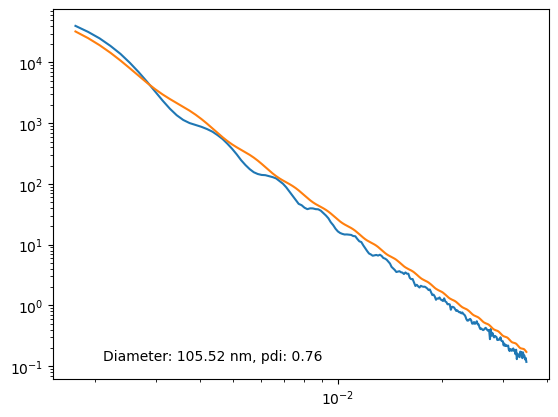

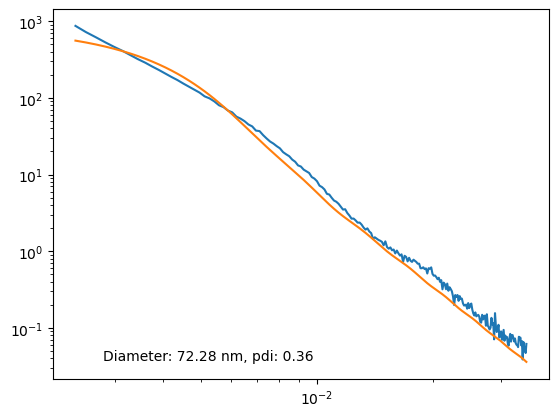

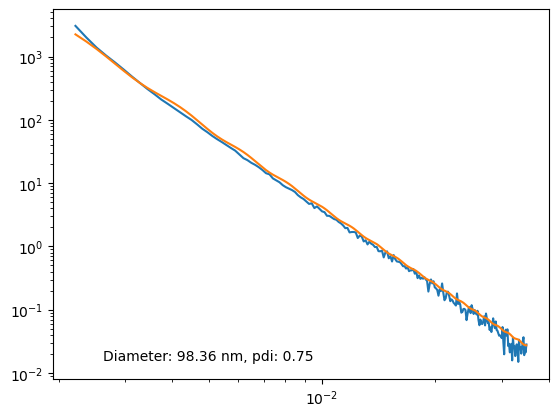

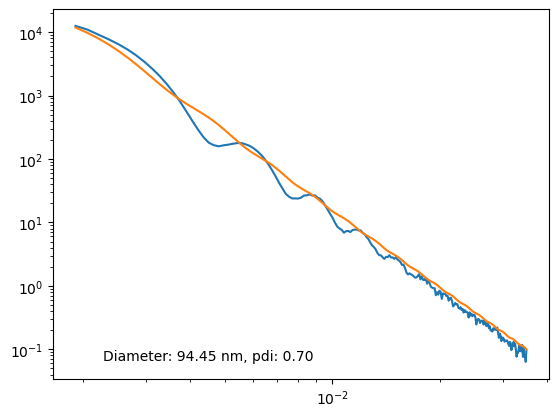

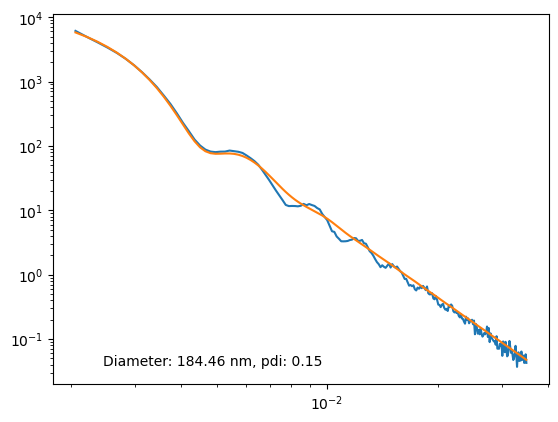

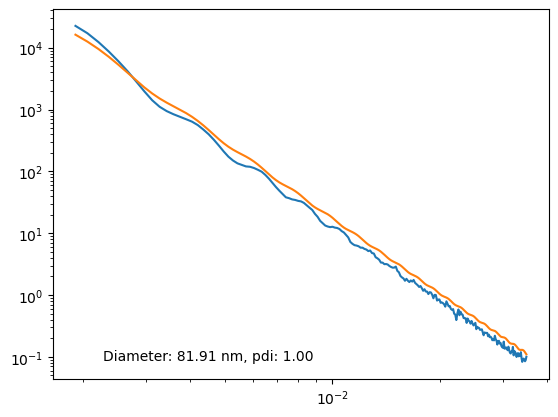

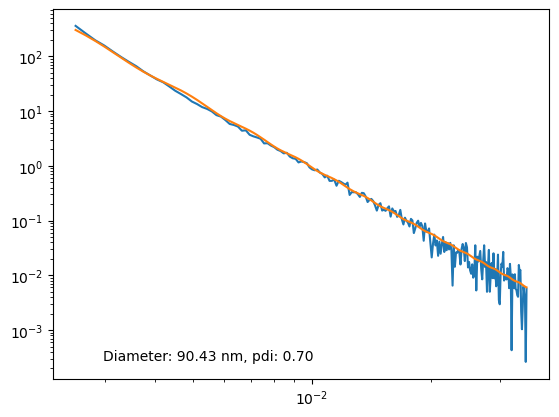

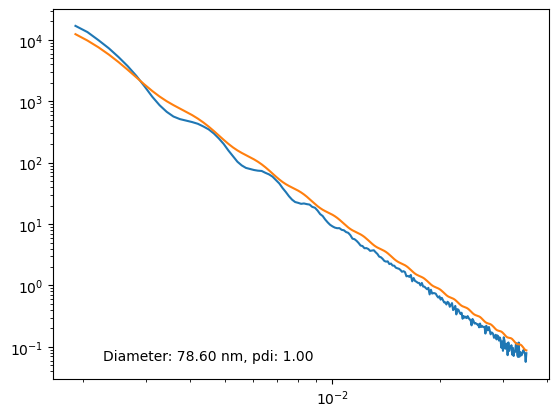

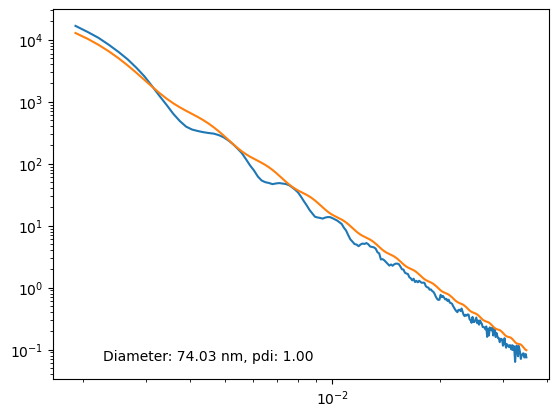

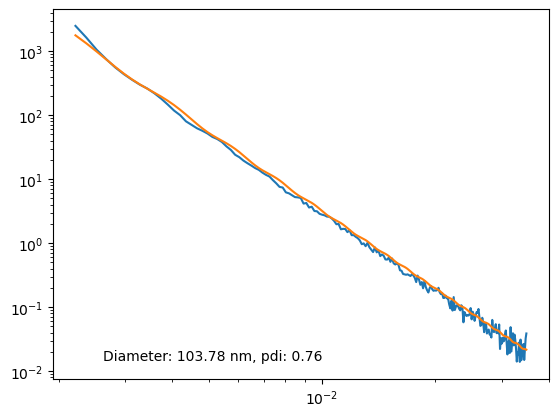

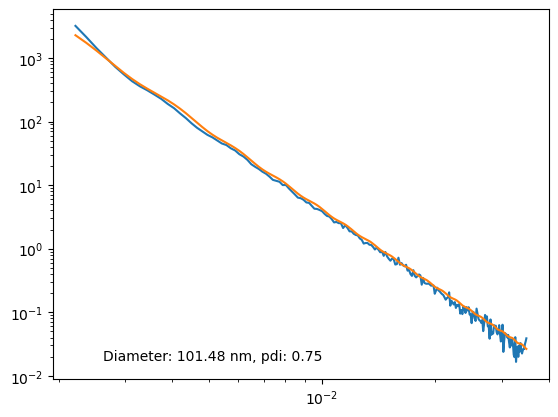

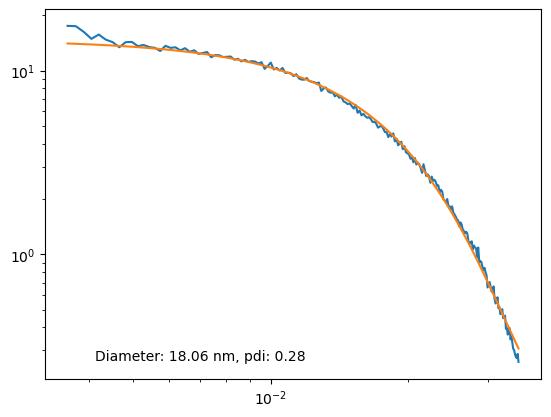

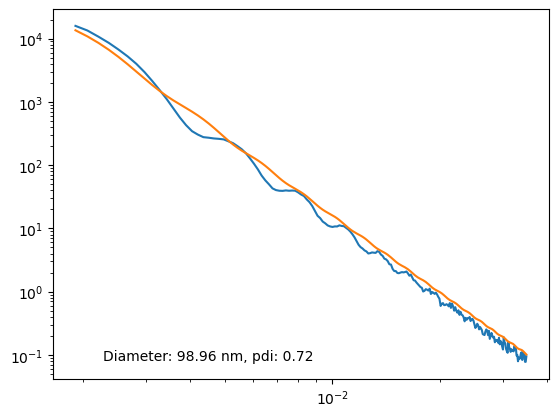

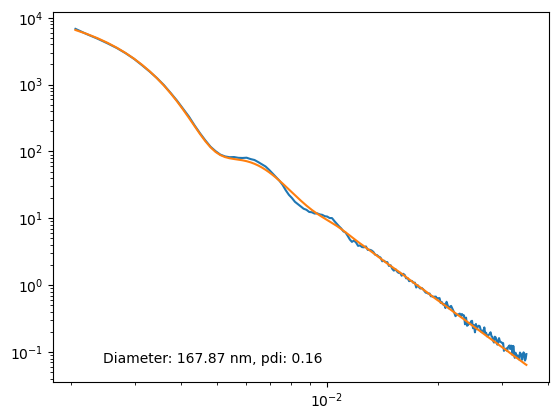

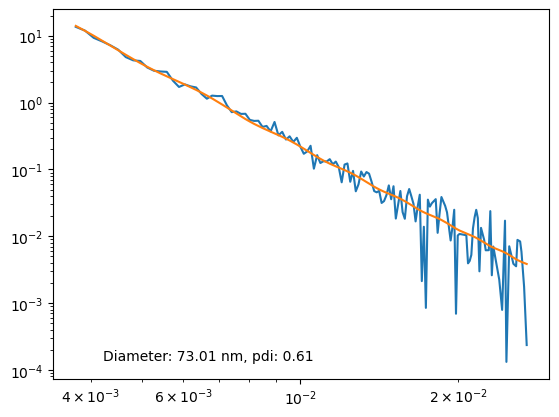

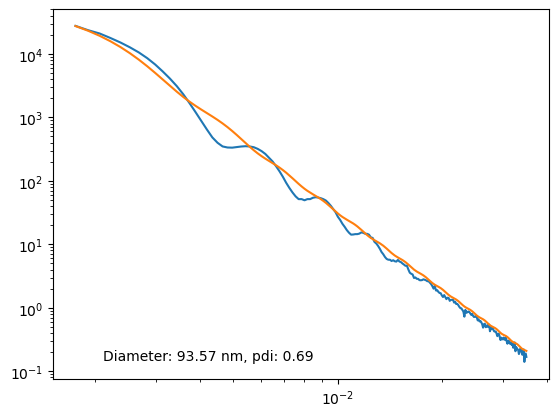

In [32]:
for uuid_val, entry in processing_dataset.items():
    try:
        sphere_d = entry['sphere_fit_results']['radius']*2/10
        sphere_pdi = entry['sphere_fit_results']['radius_pd']
    
        problem = entry['sphere_fit_problem']
    except KeyError:
        continue


    data = problem.fitness._data
    Icalc = problem.fitness.Iq_calc

    fig, ax = plt.subplots()

    ax.loglog(data.x, data.y, label = 'measured')
    ax.loglog(data.x, Icalc, label = 'fit')
    ax.text(0.1, 0.05, f'Diameter: {sphere_d:.2f} nm, pdi: {sphere_pdi:.2f}', transform = ax.transAxes)

## Write results to disk

In [33]:
uuid_vals = []
amplitude = []
phase = []
sum_ap = []
raw_rmse = []
statuses = []
sphere_diameter = []
sphere_pdi = []

for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            uuid_vals.append(uuid_val)
            amplitude.append(None)
            phase.append(None)
            sum_ap.append(None)
            statuses.append('failed')
            sphere_diameter.append(None)
            sphere_pdi.append(None)
            raw_rmse.append(None)
            continue
        else:
            raise KeyError
    except KeyError:
        uuid_vals.append(uuid_val)
        amplitude.append(entry['amplitude_distance'])
        phase.append(entry['phase_distance'])
        sum_ap.append(entry['ap_sum_distance'])
        raw_rmse.append(entry['rmse_raw'])
        statuses.append('success')
        sphere_diameter.append(entry['sphere_fit_results']['radius']*2/10)
        sphere_pdi.append(entry['sphere_fit_results']['radius_pd'])
    

In [34]:
results_df = pd.DataFrame({'uuid':uuid_vals, 'amplitude_distance':amplitude, 'phase_distance':phase, 'sum_ap_distance':sum_ap, 'raw_rmse_distance':raw_rmse, 'sphere_diameter_nm':sphere_diameter, 'sphere_pdi':sphere_pdi, 'processes_status':statuses})

In [48]:
results_df.to_csv('distance_results_Round2Random.csv')

In [36]:
results_df

,uuid,amplitude_distance,phase_distance,sum_ap_distance,raw_rmse_distance,sphere_diameter_nm,sphere_pdi,processes_status
0,c563cb4d-d727-437f-9a6a-fef3eccbbe50,0.994091,0.528099,1.522190,0.255116,75.943310,1.000000,success
1,3ef8b92f-f2eb-4134-ad6c-ae3329408457,1.033666,0.514583,1.548249,0.264217,101.152856,0.730457,success
2,0507cf19-673b-4d6b-922e-c21f718ad4fe,0.930899,0.558692,1.489590,0.254219,74.915296,1.000000,success
3,82fc5e1c-5d6e-4ecd-82c3-eb912535a0d7,0.734126,0.257073,0.991199,0.298204,63.510045,0.136633,success
4,9964ab9f-5b01-4ae2-b492-a1be55ce083f,0.889431,0.539605,1.429035,0.302280,177.793802,0.150685,success
5,d263a9a8-70c2-49a4-badb-03a72fa16632,1.006234,0.500148,1.506382,0.314632,134.978874,0.162232,success
6,586ae478-4dab-4d7d-9382-ab359a49387a,NaN,NaN,NaN,NaN,NaN,NaN,failed
7,7386215f-7150-48a6-b35f-96cbe5b743cf,1.025885,0.511102,1.536987,0.259520,84.355629,1.000000,success
8,d408858a-bbae-4227-8e64-6c368a1f3398,0.969823,0.564145,1.533968,0.256223,74.557883,1.000000,success
9,0c042bd5-e5ed-4460-9bb9-d8556dba293c,1.027321,0.533037,1.560358,0.258701,75.644231,1.000000,success


## Serialize scaled intensities

In [37]:
intensity_data = {}

q_grid_list = q_grid.tolist()

for uuid_val, entry in processing_dataset.items():
    I_scaled = entry.get('I_scaled')
    if I_scaled is not None:
        I_scaled = I_scaled.tolist()
    intensity_data[uuid_val] = {'q_grid':q_grid_list, 'I_scaled':I_scaled}

In [40]:
with open('scaled_intensities_Round2Random.json', 'w') as f:
    json.dump(intensity_data, f)

## Phase diagram plot

In [3]:
with open('scaled_intensities_Round2Random.json', 'r') as f:
    intensities = json.load(f)

with open('constants_Round2_2025_01_13.json', 'r') as f:
    constants = json.load(f)

In [4]:
sample_table = pd.read_csv('synth_table_Round2Random.csv')

In [5]:
x_name = 'TEOS'
y_name = 'water'
y_2_name = 'ammonia'

x_min = constants[x_name]['minimum_volume_fraction']
x_max = constants[x_name]['maximum_volume_fraction']
y_min = constants[y_name]['minimum_volume_fraction']
y_max = constants[y_name]['maximum_volume_fraction']

y_2_min = constants[y_2_name]['minimum_volume_fraction']
y_2_max = constants[y_2_name]['maximum_volume_fraction']

bounds = np.array([[x_min, y_min], [x_max, y_max]])
bounds_2 = np.array([[x_min, y_2_min], [x_max, y_2_max]])

In [6]:
bounds

array([[0.005, 0.005],
       [0.1  , 0.15 ]])

In [7]:
bounds_2

array([[0.005, 0.005],
       [0.1  , 0.1  ]])

I scaled None
<function plot_phasemap.<locals>.<lambda> at 0x7f25a43f67a0>
<function plot_phasemap.<locals>.<lambda> at 0x7f25a3c91260>


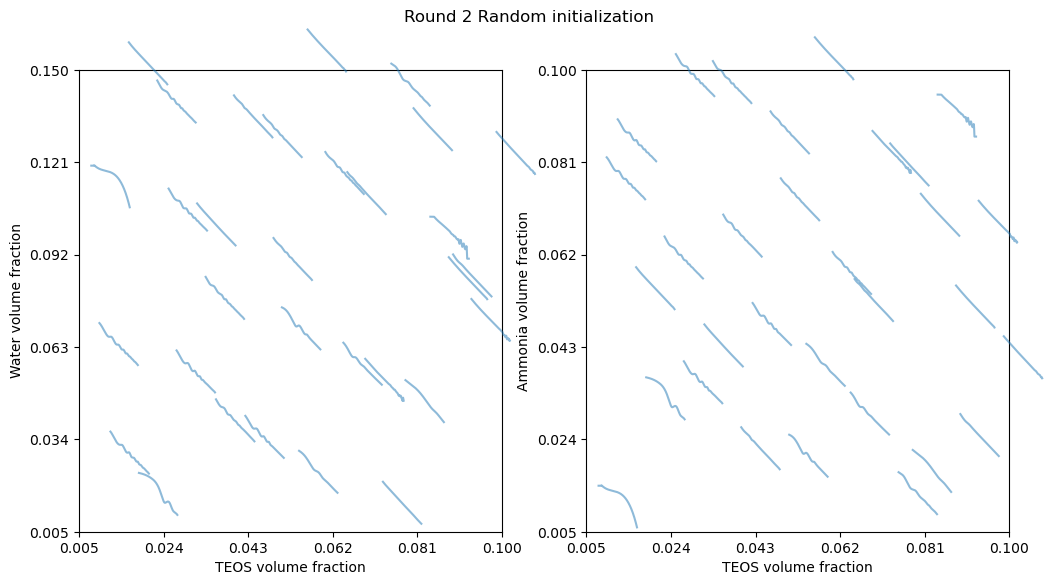

In [20]:
x_key = 'teos_vol_frac'
y_key = 'water_vol_frac'
y_2_key = 'ammonia_vol_frac'

fig, ax = plt.subplots(1,2, figsize = (12,6))

c_1 = []
s = []
c_2 = []
for i, row in sample_table.iterrows():
    uuid_val = row['uuid']

    x_val = row[x_key]
    y_val = row[y_key]
    y_2_val = row[y_2_key]
    
    intensity = intensities[uuid_val]
    

    q = intensity['q_grid']
    I = intensity['I_scaled']

    if I == None:
        print('I scaled None')
        continue

    else:
        c_1.append([x_val, y_val])
        s.append(I)
        c_2.append([x_val, y_2_val])

s = np.array(s)

pd_utils.plot_phasemap(bounds, ax[0], c_1, s, scale_axis=True)
pd_utils.plot_phasemap(bounds_2, ax[1], c_2, s)


ax[0].set_xlabel('TEOS volume fraction')
ax[0].set_ylabel('Water volume fraction')
ax[1].set_xlabel('TEOS volume fraction')
ax[1].set_ylabel('Ammonia volume fraction')


fig.suptitle('Round 2 Random initialization')
plt.savefig('Phaseplot_Round2Random.png', dpi = 300)

In [11]:
ax[0].get_xlim()

(np.float64(0.0), np.float64(1.0))

In [15]:
ax[1].get_xticks()

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

## Split rmse and apdist samples



In [28]:
synthesis_files = ['/home/bgpelkie/Code/silica-np-synthesis/2024_10_04_RandomBaseline_v2/Sample_table_2024_10_04_randomsampleV2.csv', 
                   '/home/bgpelkie/Code/silica-np-synthesis/2024_10_07_randomSampleV3/Sample_table_2024_10_07_randomsampleV3.csv', 
                   '/home/bgpelkie/Code/silica-np-synthesis/2024_10_17_RandomBaselineV4/Sample_table_2024_10_17_RandomBaselineV4.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/2024_12_16_DistCompare_80nmTarget_round1/Sample_table_2024_12_16_CompareOpt_80nmTarget_Round1_apdist.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/2024_12_16_DistCompare_80nmTarget_round1/Sample_table_2024_12_16_CompareOpt_80nmTarget_Round1_rmsedist.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/2024_12_18_DistCompare_80nmTarget_round2/Sample_table_2024_12_18_CompareOpt_80nmTarget_Round2_apdist.csv', 
                   '/home/bgpelkie/Code/silica-np-synthesis/2024_12_18_DistCompare_80nmTarget_round2/Sample_table_2024_12_18_CompareOpt_80nmTarget_Round2_rmsedist.csv'] 

In [29]:
fp2name = {'/home/bgpelkie/Code/silica-np-synthesis/2024_10_07_randomSampleV3/Sample_table_2024_10_07_randomsampleV3.csv':'2024_10_07_randomSampleV3', 
           '/home/bgpelkie/Code/silica-np-synthesis/2024_10_04_RandomBaseline_v2/Sample_table_2024_10_04_randomsampleV2.csv':'2024_10_04_RandomBaseline_v2', 
           '/home/bgpelkie/Code/silica-np-synthesis/2024_10_17_RandomBaselineV4/Sample_table_2024_10_17_RandomBaselineV4.csv':'2024_10_17_RandomBaselineV4',
           '/home/bgpelkie/Code/silica-np-synthesis/2024_12_16_DistCompare_80nmTarget_round1/Sample_table_2024_12_16_CompareOpt_80nmTarget_Round1_apdist.csv':'2024_12_16_Optimize_APdist',
           '/home/bgpelkie/Code/silica-np-synthesis/2024_12_16_DistCompare_80nmTarget_round1/Sample_table_2024_12_16_CompareOpt_80nmTarget_Round1_rmsedist.csv':'2024_12_16_Optimize_rmse',
           '/home/bgpelkie/Code/silica-np-synthesis/2024_12_18_DistCompare_80nmTarget_round2/Sample_table_2024_12_18_CompareOpt_80nmTarget_Round2_apdist.csv':'2024_12_18_Optimize_APdist', 
           '/home/bgpelkie/Code/silica-np-synthesis/2024_12_18_DistCompare_80nmTarget_round2/Sample_table_2024_12_18_CompareOpt_80nmTarget_Round2_rmsedist.csv':'2024_12_18_Optimize_rmse',
          }



In [30]:
random_files = ['2024_10_07_randomSampleV3', '2024_10_04_RandomBaseline_v2', '2024_10_17_RandomBaselineV4']
apdist_files = ['2024_12_16_Optimize_APdist', '2024_12_18_Optimize_APdist']
rmse_files = ['2024_12_16_Optimize_rmse', '2024_12_18_Optimize_rmse']

In [31]:
synth_tables = []

random_uuids = []
apdist_uuids = []
rmse_uuids = []

count = 0
for fp in synthesis_files:
    data= pd.read_csv(fp)
    name = fp2name[fp]
    data['campaign'] = [name]*len(data)
    synth_tables.append(data)
    count += len(data)
    if name in random_files:
        random_uuids.extend(list(data['uuid']))
    if name in apdist_files:
        apdist_uuids.extend(list(data['uuid']))
    if name in rmse_files:
        rmse_uuids.extend(list(data['uuid']))
        
    

synth_table = pd.concat(synth_tables, axis = 0)

In [32]:
apdist_samples = random_uuids.copy()
apdist_samples.extend(apdist_uuids)

rmse_samples = random_uuids.copy()
rmse_samples.extend(rmse_uuids)

## Plot final ranked order of best samples APdist

In [37]:
sum_ap = {}
for uuid_val, entry in processing_dataset.items():
    if uuid_val in apdist_samples:
        try:
            
            status = entry['status']
            if status == 'failed':
                continue
            else:
                raise KeyError
                
        except KeyError:
            sum_ap[uuid_val] = entry['ap_sum_distance']
    else:
        continue


uuids = np.array(list(sum_ap.keys()))
rmses = list(sum_ap.values())
uuid_sorted_sum = uuids[np.argsort(rmses)]

In [43]:

with PdfPages('ranked_apdist_results.pdf') as pdf:
    for i, uuid_val in enumerate(uuid_sorted_sum):

        entry  = processing_dataset[uuid_val]
        I_scaled = entry['I_scaled']
        
        distance = sum_ap[uuid_val]

        sphere_d = entry['sphere_fit_results']['radius']*2/10
        sphere_pdi = entry['sphere_fit_results']['radius_pd']


    
        fig, ax = plt.subplots()
        ax.loglog(10**q_grid, 10**target_I, label = 'target')
        ax.loglog(10**q_grid, 10**I_scaled, label = 'measured (cleaned)')
        ax.set_xlabel('q [1/A]')
        ax.set_title(uuid_val)
        ax.text(0.1, 0.1, f'Rank: {i}\nsum distance: {distance:.2f}\nsphere diameter: {sphere_d:.2f} nm\nsphere pdi: {sphere_pdi:.2f}', transform = ax.transAxes)
        ax.legend()
        pdf.savefig()
        plt.close()

## Plot raw RMSE

In [39]:
raw_rmse = {}
for uuid_val, entry in processing_dataset.items():
    if uuid_val in rmse_samples:
        try:
            
            status = entry['status']
            if status == 'failed':
                continue
            else:
                raise KeyError
                
        except KeyError:
            raw_rmse[uuid_val] = entry['rmse_raw']
    else:
        continue


uuids = np.array(list(raw_rmse.keys()))
rmses = list(raw_rmse.values())
uuid_sorted_rmseraw = uuids[np.argsort(rmses)]

In [44]:
with PdfPages('ranked_rawrmse_results.pdf') as pdf:
    for i, uuid_val in enumerate(uuid_sorted_rmseraw):

        entry  = processing_dataset[uuid_val]
        I_scaled = entry['I_scaled']
        
        distance = raw_rmse[uuid_val]

        sphere_d = entry['sphere_fit_results']['radius']*2/10
        sphere_pdi = entry['sphere_fit_results']['radius_pd']


    
        fig, ax = plt.subplots()
        ax.loglog(10**q_grid, 10**target_I, label = 'target')
        ax.loglog(10**q_grid, 10**I_scaled, label = 'measured')
        ax.set_xlabel('q [1/A]')
        ax.set_title(uuid_val)
        ax.text(0.1, 0.1, f'Rank: {i}\nrmse_raw distance: {distance:.2f}\nsphere diameter: {sphere_d:.2f} nm\nsphere pdi: {sphere_pdi:.2f}', transform = ax.transAxes)
        ax.legend()
        pdf.savefig()
        plt.close()